# 01 · S3WD-GWB 动态循环实验（Airline）


In [23]:
# Step 0 · 环境初始化与依赖检查
from __future__ import annotations

import json
import math
import os
import sys
import platform
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 50)

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

RUNTIME_INFO = {
    'python': sys.version.split()[0],
    'platform': platform.platform(),
    'project_root': str(PROJECT_ROOT),
}
print('【步骤0摘要】已初始化运行环境：', RUNTIME_INFO)



【步骤0摘要】已初始化运行环境： {'python': '3.11.5', 'platform': 'Windows-10-10.0.26100-SP0', 'project_root': 'E:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验'}


In [24]:
# Step 1 · 载入配置并展开变量
from s3wdlib.config_loader import load_yaml_cfg, extract_vars, show_cfg

CONFIG_PATH = PROJECT_ROOT / 'configs' / 's3wd_airline_dynamic.yaml'
CFG = load_yaml_cfg(str(CONFIG_PATH))
V = extract_vars(CFG)
show_cfg(CFG)
print('【步骤1摘要】配置文件加载完成，关键键数=', len(V))



【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.8, 'bandwidth_scale': 1.0, 'use_faiss': True, 'faiss_gpu': True}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- DYN: {'strategy': 'windowed_pso', 'step': 256, 'window_size': 512, 'target_bnd': 0.18, 'ema_alpha': 0.6, 'median_window': 3, 'keep_gap': 0.02, 'fallback_rule': True, 'gamma

In [25]:
# Step 2 · 加载数据集并准备标签
from s3wdlib.data_io import load_table_auto
from sklearn.datasets import make_classification

raw_data_path = Path(V['DATA_PATH'])
if not raw_data_path.is_absolute():
    data_path = (CONFIG_PATH.parent / raw_data_path).resolve()
else:
    data_path = raw_data_path

if data_path.exists():
    X_df, y_sr = load_table_auto(
        str(data_path),
        label_col=V.get('LABEL_COL'),
        positive_label=V.get('POSITIVE_LABEL', 1),
        continuous_label=V.get('CONT_LABEL'),
        threshold=V.get('CONT_THRESH'),
        threshold_op=V.get('CONT_OP', '>='),
    )
    data_source = f'航空延误真实数据: {data_path.name}'
else:
    n_samples = 12000
    n_features = 32
    X_arr, y_arr = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=18,
        n_redundant=6,
        n_repeated=0,
        n_clusters_per_class=2,
        weights=[0.6, 0.4],
        class_sep=1.2,
        random_state=int(V.get('SEED', 42)),
    )
    X_df = pd.DataFrame(X_arr, columns=[f'feat_{i:02d}' for i in range(n_features)])
    y_sr = pd.Series(y_arr, name='label')
    data_source = '合成数据 (make_classification) 用于演示'
    print(f'⚠️ 未找到航空数据，自动生成 {n_samples} 条合成样本。')

print('【步骤2摘要】数据来源：', data_source, '；样本形状=', X_df.shape)



【数据加载完毕】样本数=1000000，特征数=9，正类比例=0.1559
【步骤2摘要】数据来源： 航空延误真实数据: airlines_train_regression_1000000.arff ；样本形状= (1000000, 9)


In [26]:
# Step 3 · 按配置划分训练/验证/测试集
from sklearn.model_selection import train_test_split

test_size = float(V['TEST_SIZE'])
val_size = float(V['VAL_SIZE'])
seed = int(V['SEED'])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df, y_sr, test_size=test_size, stratify=y_sr, random_state=seed
)

if 0 < val_size < 1:
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_size, stratify=y_train_full, random_state=seed
    )
else:
    split_idx = int((1.0 - min(val_size, 0.5)) * len(X_train_full))
    X_train_sub, X_val = X_train_full.iloc[:split_idx].copy(), X_train_full.iloc[split_idx:].copy()
    y_train_sub, y_val = y_train_full.iloc[:split_idx].copy(), y_train_full.iloc[split_idx:].copy()

print('【步骤3摘要】训练/验证/测试规模=', len(X_train_sub), len(X_val), len(X_test))



【步骤3摘要】训练/验证/测试规模= 490000 210000 300000


In [27]:
# Step 4 · 归一化与特征分层
from sklearn.preprocessing import MinMaxScaler
from s3wdlib.features import rank_features_mi, make_levels

scaler = MinMaxScaler()
scaler.fit(X_train_sub)
Xtr2 = pd.DataFrame(scaler.transform(X_train_sub), columns=X_train_sub.columns)
Xva2 = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
Xte2 = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
Xtr_full2 = pd.DataFrame(scaler.transform(X_train_full), columns=X_train_full.columns)

feat_rank, feat_scores = rank_features_mi(Xtr2, y_train_sub)
L1, L2, L3 = make_levels(feat_rank, V.get('LEVEL_PCTS', [0.6, 0.8, 1.0]))

print('【步骤4摘要】特征按互信息排序完成，层级规模=', len(L1), len(L2), len(L3))



【步骤4摘要】特征按互信息排序完成，层级规模= 5 7 9


In [28]:
# Step 5 · 拟合 GWB 三层概率估计器
from s3wdlib.gwb import GWBProbEstimator

gwb_kwargs = {
    'k': int(V['GWB_K']),
    'mode': V.get('GWB_mode', 'epanechnikov'),
    'bandwidth': V.get('GWB_bandwidth'),
    'bandwidth_scale': V.get('GWB_bandwidth_scale', 1.0),
    'use_faiss': bool(V.get('GWB_use_faiss', True)),
    'faiss_gpu': bool(V.get('GWB_faiss_gpu', True)),
}
gwb_kwargs = {k: v for k, v in gwb_kwargs.items() if v is not None}

gwb_L1 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L1], y_train_sub.values)
gwb_L2 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L2], y_train_sub.values)
gwb_L3 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L3], y_train_sub.values)

p1_val = gwb_L1.predict_proba(Xva2[L1])
p2_val = gwb_L2.predict_proba(Xva2[L2])
p3_val = gwb_L3.predict_proba(Xva2[L3])

p1_test = gwb_L1.predict_proba(Xte2[L1])
p2_test = gwb_L2.predict_proba(Xte2[L2])
p3_test = gwb_L3.predict_proba(Xte2[L3])

print('【步骤5摘要】验证/测试概率已生成，示例=', float(np.mean(p1_val[:3])))



【步骤5摘要】验证/测试概率已生成，示例= 0.1923119810387005


In [29]:
# Step 6 · PSO 学习静态阈值
from s3wdlib.objective import S3WDParams
from s3wdlib.trainer import PSOParams, pso_learn_thresholds

s3_params = S3WDParams(
    c1=V['S3_c1'],
    c2=V['S3_c2'],
    xi_min=V['S3_xi_min'],
    theta_pos=V['S3_theta_pos'],
    theta_neg=V['S3_theta_neg'],
    sigma=V.get('S3_sigma', 3.0),
    regret_mode=V.get('S3_regret_mode', 'utility'),
    penalty_large=V['S3_penalty_large'],
    gamma_last=V.get('S3_gamma_last', True),
    gap=V.get('S3_gap', 0.02),
)

pso_params = PSOParams(
    particles=V['PSO_particles'],
    iters=V['PSO_iters'],
    w_max=V['PSO_w_max'],
    w_min=V['PSO_w_min'],
    c1=V['PSO_c1'],
    c2=V['PSO_c2'],
    seed=V['PSO_seed'],
    use_gpu=V.get('PSO_use_gpu', True),
)

(static_thresholds, static_fitness, static_detail) = pso_learn_thresholds(
    [p1_val, p2_val, p3_val],
    y_val.values,
    s3_params,
    pso_params,
)

alpha_static, beta_static, gamma_static = static_thresholds
alpha_msg = ', '.join(f'α{i+1}={v:.4f}' for i, v in enumerate(alpha_static))
beta_msg = ', '.join(f'β{i+1}={v:.4f}' for i, v in enumerate(beta_static))
print(f'【步骤6摘要】静态阈值：{alpha_msg}；{beta_msg}；γ3={float(gamma_static):.4f}')



【步骤6摘要】静态阈值：α1=0.5339, α2=0.5339, α3=0.3944；β1=0.1584, β2=0.1584, β3=0.1584；γ3=0.5000


In [30]:
# Step 7 · 静态基线评估与可视化准备
import matplotlib.pyplot as plt
from s3wdlib.evalx import classification_metrics, layer_stats
from s3wdlib.viz import probability_histogram, threshold_trajectory, drift_timeline
from s3wdlib.drift import DriftEvent

def sequential_predict(prob1, prob2, prob3, y_true, a1, b1, a2, b2, g3):
    prob1 = np.asarray(prob1, dtype=float).ravel()
    prob2 = np.asarray(prob2, dtype=float).ravel()
    prob3 = np.asarray(prob3, dtype=float).ravel()
    y_true = np.asarray(y_true, dtype=int).ravel()
    pos1 = prob1 >= a1
    neg1 = prob1 <= b1
    bnd1 = (~pos1) & (~neg1)
    pos2 = np.zeros_like(pos1, bool)
    neg2 = np.zeros_like(pos1, bool)
    if np.any(bnd1):
        prob2_sub = prob2[bnd1]
        pos2[bnd1] = prob2_sub >= a2
        neg2[bnd1] = prob2_sub <= b2
    bnd2 = bnd1 & (~pos2) & (~neg2)
    pos3 = np.zeros_like(pos1, bool)
    neg3 = np.zeros_like(pos1, bool)
    if np.any(bnd2):
        prob3_sub = prob3[bnd2]
        pos3[bnd2] = prob3_sub >= g3
        neg3[bnd2] = ~pos3[bnd2]
    y_hat = np.full_like(y_true, -1, int)
    y_hat[pos1 | pos2 | pos3] = 1
    y_hat[neg1 | neg2 | neg3] = 0
    flow = {
        'L1': (int(pos1.sum()), int(bnd1.sum()), int(neg1.sum())),
        'L2': (int(pos2.sum()), int(bnd2.sum()), int(neg2.sum())),
        'L3': (int(pos3.sum()), int(neg3.sum())),
    }
    return y_hat, flow

y_pred_static, flow_static = sequential_predict(
    p1_test, p2_test, p3_test, y_test.values,
    float(alpha_static[0]), float(beta_static[0]),
    float(alpha_static[1]), float(beta_static[1]),
    float(gamma_static),
)
mask_static = y_pred_static >= 0
metrics_static = classification_metrics(y_test.values[mask_static], y_pred_static[mask_static])

summary_static = pd.DataFrame([{
    'F1': metrics_static['F1'],
    'BAC': metrics_static['BAC'],
    'Prec': metrics_static['Prec'],
    'Rec': metrics_static['Rec'],
    'MCC': metrics_static['MCC'],
    'Kappa': metrics_static['Kappa'],
    'AUC': metrics_static.get('AUC', np.nan),
}])

static_results = {
    'predictions': y_pred_static,
    'flow': flow_static,
    'metrics': summary_static,
    'probabilities': {'L1': p1_test, 'L2': p2_test, 'L3': p3_test},
}

print('【步骤7摘要】静态基线 F1={:.4f}, BAC={:.4f}'.format(summary_static['F1'][0], summary_static['BAC'][0]))



【步骤7摘要】静态基线 F1=0.1407, BAC=0.5243


In [31]:
# Step 8 · 构建动态流程工厂函数
from s3wdlib.dyn_threshold import adapt_thresholds_windowed_pso, adapt_thresholds_rule_based
from s3wdlib.incremental import PosteriorUpdater, latest_estimator_for_flow
from s3wdlib.drift import DriftDetector

def make_updater(feature_names: List[str]) -> PosteriorUpdater:
    return PosteriorUpdater(
        estimator_factory=lambda: GWBProbEstimator(**gwb_kwargs),
        buffer_size=min(8192, len(X_train_full)),  # 限定缓存规模以适配 6GB GPU
        cache_strategy='sliding',
        rebuild_interval=4096,  # 拉大重建间隔降低频次
        min_rebuild_interval=1024,
        drift_shrink=0.6,
        random_state=seed,
    )

def init_dynamic_components():
    up1 = make_updater(L1)
    up2 = make_updater(L2)
    up3 = make_updater(L3)
    for updater, cols in [(up1, L1), (up2, L2), (up3, L3)]:
        updater.reset()
        updater.update(Xtr2[cols].to_numpy(), y_train_sub.values)
    det = DriftDetector(method='kswin', window_size=160, stat_size=48, significance=0.01, cooldown=120)
    return up1, up2, up3, det

print('【步骤8摘要】动态组件工厂函数就绪，可按需重置。')



【步骤8摘要】动态组件工厂函数就绪，可按需重置。


In [32]:
# Step 9 · 封装动态循环实验函数
from dataclasses import asdict

def run_streaming(enable_dynamic: bool = True, window_size: int = 384):
    if not enable_dynamic:
        y_hat, flow = sequential_predict(
            p1_test, p2_test, p3_test, y_test.values,
            float(alpha_static[0]), float(beta_static[0]),
            float(alpha_static[1]), float(beta_static[1]),
            float(gamma_static),
        )
        metrics = classification_metrics(y_test.values, y_hat)
        return {
            'mode': 'static',
            'y_pred': y_hat,
            'flows': [flow],
            'metrics': metrics,
            'threshold_history': [{
                'step': 0,
                'alpha1': float(alpha_static[0]),
                'beta1': float(beta_static[0]),
                'alpha2': float(alpha_static[1]),
                'beta2': float(beta_static[1]),
                'gamma3': float(gamma_static),
            }],
            'probabilities': {'L1': p1_test, 'L2': p2_test, 'L3': p3_test},
            'drift_events': [],
        }

    window_size = max(64, int(window_size))
    up1, up2, up3, det = init_dynamic_components()
    history_state = {}
    threshold_history = []
    flows = []
    drift_events = []
    preds_all: List[np.ndarray] = []
    truths_all: List[np.ndarray] = []
    prob_collect_L1: List[np.ndarray] = []
    prob_collect_L2: List[np.ndarray] = []
    prob_collect_L3: List[np.ndarray] = []
    metrics_chunks: List[Dict[str, float]] = []

    baseline_alpha = np.asarray(alpha_static, dtype=float)
    baseline_beta = np.asarray(beta_static, dtype=float)
    baseline_gamma = float(gamma_static)

    total = len(Xte2)
    progress = tqdm(range(0, total, window_size), desc='动态流推理', leave=False)
    for start in progress:
        end = min(start + window_size, total)
        X_batch = Xte2.iloc[start:end]
        y_batch = y_test.iloc[start:end]
        if X_batch.empty:
            continue

        est1 = latest_estimator_for_flow(up1)
        est2 = latest_estimator_for_flow(up2)
        est3 = latest_estimator_for_flow(up3)
        prob1 = est1.predict_proba(X_batch[L1]) if est1 is not None else gwb_L1.predict_proba(X_batch[L1])
        prob2 = est2.predict_proba(X_batch[L2]) if est2 is not None else gwb_L2.predict_proba(X_batch[L2])
        prob3 = est3.predict_proba(X_batch[L3]) if est3 is not None else gwb_L3.predict_proba(X_batch[L3])
        prob_collect_L1.append(prob1)
        prob_collect_L2.append(prob2)
        prob_collect_L3.append(prob3)

        adapt_result = adapt_thresholds_windowed_pso(
            [prob1, prob2, prob3],
            y_batch.values,
            s3_params,
            keep_gap=s3_params.gap,
            history=history_state,
            window_size=len(X_batch),
            seed=seed + start,
            ema_alpha=0.6,
            median_window=3,
            fallback_rule=True,
        )
        history_state = adapt_result.history
        cur_alpha = adapt_result.alphas
        cur_beta = adapt_result.betas
        cur_gamma = adapt_result.gamma if adapt_result.gamma is not None else baseline_gamma

        det_value = float(np.mean(prob1))
        event = det.update(det_value, index=end)
        if event is not None:
            drift_events.append(event)

        y_hat_chunk, flow_chunk = sequential_predict(
            prob1, prob2, prob3, y_batch.values,
            float(cur_alpha[0]), float(cur_beta[0]),
            float(cur_alpha[1]), float(cur_beta[1]),
            float(cur_gamma),
        )
        preds_all.append(y_hat_chunk)
        truths_all.append(y_batch.values)
        flows.append(flow_chunk)
        metrics_chunks.append(classification_metrics(y_batch.values, y_hat_chunk))

        threshold_history.append({
            'step': len(threshold_history),
            'alpha1': float(cur_alpha[0]),
            'beta1': float(cur_beta[0]),
            'alpha2': float(cur_alpha[1]),
            'beta2': float(cur_beta[1]),
            'gamma3': float(cur_gamma),
            'fitness': float(adapt_result.fitness),
            'bnd_ratio': float(adapt_result.details.get('bnd_ratio', np.nan)),
        })

        progress.set_postfix({
            'chunk': f'{end}/{total}',
            'α1': f'{cur_alpha[0]:.3f}',
            'β1': f'{cur_beta[0]:.3f}',
            'drifts': len(drift_events),
        })

        up1.update(X_batch[L1].to_numpy(), y_batch.values, drift_event=event)
        up2.update(X_batch[L2].to_numpy(), y_batch.values, drift_event=event)
        up3.update(X_batch[L3].to_numpy(), y_batch.values, drift_event=event)

    progress.close()

    y_pred_all = np.concatenate(preds_all)
    y_true_all = np.concatenate(truths_all)
    metrics_total = classification_metrics(y_true_all, y_pred_all)

    return {
        'mode': 'dynamic',
        'y_pred': y_pred_all,
        'flows': flows,
        'metrics': metrics_total,
        'threshold_history': threshold_history,
        'probabilities': {
            'L1': np.concatenate(prob_collect_L1),
            'L2': np.concatenate(prob_collect_L2),
            'L3': np.concatenate(prob_collect_L3),
        },
        'drift_events': drift_events,
        'chunk_metrics': metrics_chunks,
    }

print('【步骤9摘要】动态循环函数已定义，可复用 run_streaming(enable_dynamic=...) 调用。')



【步骤9摘要】动态循环函数已定义，可复用 run_streaming(enable_dynamic=...) 调用。


In [33]:
# Step 10 · 对比实验：静态流与动态流
stream_static = run_streaming(enable_dynamic=False)
stream_dynamic = run_streaming(enable_dynamic=True, window_size=384)
static_f1 = float(stream_static['metrics']['F1'])
dynamic_f1 = float(stream_dynamic['metrics']['F1'])
baseline_f1 = float(static_results['metrics']['F1'][0])
if not np.isclose(static_f1, baseline_f1, atol=1e-6):
    raise AssertionError('静态 streaming 结果与基线不一致')
comparison_df = pd.DataFrame([
    {'模式': '静态基线', **stream_static['metrics']},
    {'模式': '动态循环', **stream_dynamic['metrics']},
])
display(comparison_df)
print('【步骤10摘要】静态 F1={:.4f}，动态 F1={:.4f}（一致性校验通过）'.format(static_f1, dynamic_f1))


[INFO] PosteriorUpdater 已重置，等待新批次样本。
[INFO] 【滑动窗口】缓存超限，丢弃最早 481808 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] PosteriorUpdater 已重置，等待新批次样本。
[INFO] 【滑动窗口】缓存超限，丢弃最早 481808 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] PosteriorUpdater 已重置，等待新批次样本。
[INFO] 【滑动窗口】缓存超限，丢弃最早 481808 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。


动态流推理:   0%|          | 0/782 [00:00<?, ?it/s]

[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6913, 0.5473, 0.6126], β=[0.2541, 0.2677, 0.2801], 边界占比=0.542, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04E840 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04E8D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04EB00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7224, 0.5936, 0.5866], β=[0.2755, 0.2079, 0.2493], 边界占比=0.478, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.647, 0.5502, 0.6226], β=[0.2737, 0.2394, 0.2609], 边界占比=0.505, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB051F10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB051CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB051D60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6534, 0.599, 0.5732], β=[0.2848, 0.2227, 0.2658], 边界占比=0.510, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.604, 0.6376, 0.6594], β=[0.2976, 0.2521, 0.2681], 边界占比=0.486, IG=0.0143, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04E2A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04E110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAC1CE50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6349, 0.6635, 0.6763], β=[0.2899, 0.2712, 0.2374], 边界占比=0.485, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5838, 0.6458, 0.7441], β=[0.2805, 0.3062, 0.1866], 边界占比=0.339, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546631BA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546631830 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB39AFD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6857, 0.6145, 0.6643], β=[0.2448, 0.2774, 0.2449], 边界占比=0.498, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6456, 0.5809, 0.61], β=[0.2714, 0.2532, 0.3732], 边界占比=0.368, IG=0.0071, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546604E80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546605050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546604FC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6222, 0.6474, 0.6666], β=[0.2939, 0.2819, 0.3219], 边界占比=0.219, IG=0.0171, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5896, 0.6302, 0.6713], β=[0.2581, 0.2583, 0.3666], 边界占比=0.459, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546605C20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546605BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546605CA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5964, 0.7872, 0.7234], β=[0.255, 0.3467, 0.3536], 边界占比=0.333, IG=0.0247, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5955, 0.7364, 0.6969], β=[0.2734, 0.2352, 0.3209], 边界占比=0.348, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546606B60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546606C30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546606D80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6286, 0.8898, 0.7016], β=[0.2371, 0.176, 0.263], 边界占比=0.624, IG=0.0093, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.669, 0.8783, 0.7162], β=[0.3092, 0.1677, 0.3042], 边界占比=0.391, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546607650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546607790 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546607880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6527, 0.7793, 0.6472], β=[0.2226, 0.1818, 0.3995], 边界占比=0.425, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6231, 0.6239, 0.7511], β=[0.2908, 0.263, 0.3809], 边界占比=0.341, IG=0.0220, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546604360 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235466042F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546604300 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6379, 0.6416, 0.5382], β=[0.3108, 0.3646, 0.2921], 边界占比=0.258, IG=0.0113, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.598, 0.5905, 0.5623], β=[0.2889, 0.3317, 0.1926], 边界占比=0.327, IG=0.0223, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546605680 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235466058F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235466056C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5484, 0.558, 0.4757], β=[0.2485, 0.3211, 0.1911], 边界占比=0.443, IG=0.0242, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5822, 0.6025, 0.5245], β=[0.2562, 0.2787, 0.2233], 边界占比=0.484, IG=0.0156, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB04DB60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB398020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0D710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6089, 0.7062, 0.5763], β=[0.3064, 0.2593, 0.2914], 边界占比=0.351, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5763, 0.7818, 0.7379], β=[0.2518, 0.279, 0.2494], 边界占比=0.474, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0E100 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0DE20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0DEF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5137, 0.748, 0.8081], β=[0.2701, 0.3117, 0.2776], 边界占比=0.346, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5185, 0.8422, 0.7466], β=[0.2288, 0.3013, 0.2284], 边界占比=0.478, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0EEA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0F090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0F070 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6598, 0.8731, 0.8157], β=[0.3033, 0.253, 0.1891], 边界占比=0.475, IG=0.0134, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5846, 0.8714, 0.5897], β=[0.284, 0.2228, 0.1428], 边界占比=0.595, IG=0.0122, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0F9F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0FCB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0FD80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8969, 0.7835, 0.7216], β=[0.3271, 0.1899, 0.1648], 边界占比=0.608, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8776, 0.614, 0.7587], β=[0.3037, 0.2305, 0.2615], 边界占比=0.462, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A108F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A10620 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A107F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 28 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8614, 0.6077, 0.697], β=[0.2874, 0.268, 0.3797], 边界占比=0.365, IG=0.0023, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7546, 0.6773, 0.673], β=[0.2448, 0.2751, 0.3769], 边界占比=0.399, IG=0.0134, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11530 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6178, 0.6198, 0.557], β=[0.1959, 0.274, 0.2988], 边界占比=0.445, IG=0.0011, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7169, 0.5681, 0.6794], β=[0.2221, 0.2829, 0.2675], 边界占比=0.468, IG=0.0114, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11EF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11EF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A11E00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6418, 0.5773, 0.6528], β=[0.2741, 0.2918, 0.1945], 边界占比=0.357, IG=0.0118, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.697, 0.6766, 0.6406], β=[0.2495, 0.2518, 0.204], 边界占比=0.596, IG=0.0037, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A12B30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A12AB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A12DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5847, 0.6416, 0.6209], β=[0.262, 0.24, 0.2354], 边界占比=0.603, IG=0.0139, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5505, 0.6032, 0.6267], β=[0.2751, 0.1752, 0.3149], 边界占比=0.365, IG=0.0159, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13B00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13CE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13C30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6383, 0.6373, 0.6626], β=[0.2818, 0.242, 0.3538], 边界占比=0.337, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7254, 0.6177, 0.7198], β=[0.2471, 0.2566, 0.3207], 边界占比=0.444, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A14630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A149C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A14780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6926, 0.6166, 0.7933], β=[0.2069, 0.2401, 0.1841], 边界占比=0.611, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6079, 0.6681, 0.6821], β=[0.2254, 0.2888, 0.0958], 边界占比=0.609, IG=0.0281, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A15440 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A15200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A15500 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6513, 0.7595, 0.7679], β=[0.2992, 0.354, 0.1618], 边界占比=0.499, IG=0.0092, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6145, 0.6965, 0.7733], β=[0.3347, 0.3342, 0.2375], 边界占比=0.333, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0D610 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0D890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A0D890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7302, 0.659, 0.7568], β=[0.333, 0.2825, 0.2617], 边界占比=0.373, IG=0.0169, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8318, 0.5521, 0.6901], β=[0.2922, 0.2942, 0.2767], 边界占比=0.319, IG=0.0118, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A10590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A10290 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A10200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7628, 0.7063, 0.7069], β=[0.268, 0.2797, 0.3105], 边界占比=0.356, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7231, 0.6446, 0.745], β=[0.2926, 0.3326, 0.341], 边界占比=0.215, IG=0.0265, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A14080 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13F10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13F10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7247, 0.7968, 0.7021], β=[0.2678, 0.2899, 0.3035], 边界占比=0.332, IG=0.0181, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6841, 0.6313, 0.5936], β=[0.2951, 0.285, 0.3516], 边界占比=0.234, IG=0.0011, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546608020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546608050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB39AA80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5929, 0.7742, 0.6231], β=[0.2742, 0.234, 0.2537], 边界占比=0.483, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7118, 0.5797, 0.7006], β=[0.3101, 0.2163, 0.3747], 边界占比=0.345, IG=0.0225, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565672D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565672A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556567330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7851, 0.5754, 0.6464], β=[0.2798, 0.2066, 0.2552], 边界占比=0.424, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7617, 0.5845, 0.6667], β=[0.3342, 0.26, 0.252], 边界占比=0.429, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556567BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556567DC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556567D00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6739, 0.6367, 0.6246], β=[0.3131, 0.2783, 0.2227], 边界占比=0.379, IG=0.0139, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.619, 0.6409, 0.6652], β=[0.2694, 0.3041, 0.2021], 边界占比=0.474, IG=0.0093, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565689B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556568A80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565689D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6525, 0.6373, 0.7327], β=[0.3165, 0.3276, 0.2778], 边界占比=0.308, IG=0.0034, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6213, 0.7383, 0.8761], β=[0.3426, 0.3735, 0.2001], 边界占比=0.346, IG=0.0039, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556569520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565696E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565693C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7289, 0.6701, 0.7938], β=[0.3076, 0.3563, 0.1566], 边界占比=0.473, IG=0.0091, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6745, 0.6178, 0.6154], β=[0.2735, 0.3746, 0.1912], 边界占比=0.342, IG=0.0108, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656A760 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656A610 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656A3B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8145, 0.6314, 0.5405], β=[0.3016, 0.3104, 0.2221], 边界占比=0.349, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6855, 0.6081, 0.6116], β=[0.3498, 0.3399, 0.257], 边界占比=0.336, IG=0.0244, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656B140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656B190 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656B030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6267, 0.6592, 0.7117], β=[0.3276, 0.3258, 0.273], 边界占比=0.376, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5867, 0.6052, 0.6976], β=[0.2783, 0.2794, 0.3131], 边界占比=0.247, IG=0.0075, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656BBE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656BC30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656BBD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5836, 0.6927, 0.754], β=[0.2391, 0.2127, 0.2272], 边界占比=0.619, IG=0.0081, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5703, 0.6903, 0.7127], β=[0.2406, 0.2392, 0.2427], 边界占比=0.580, IG=0.0018, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656C9C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656C850 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656C9C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5947, 0.645, 0.619], β=[0.2529, 0.2768, 0.0741], 边界占比=0.649, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 28 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5958, 0.6, 0.4624], β=[0.2221, 0.3162, 0.2227], 边界占比=0.454, IG=0.0079, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656D6E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656D5C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656D5D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6501, 0.6728, 0.5123], β=[0.2404, 0.3009, 0.1084], 边界占比=0.594, IG=0.0153, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7488, 0.7174, 0.6639], β=[0.2802, 0.2788, 0.0942], 边界占比=0.521, IG=0.0071, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556565FB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556566270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556566090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8275, 0.6775, 0.7689], β=[0.2445, 0.2368, 0.1256], 边界占比=0.704, IG=0.0167, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 28 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7531, 0.5977, 0.8451], β=[0.3258, 0.2084, 0.2249], 边界占比=0.488, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565684B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565684B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565684B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8046, 0.6611, 0.7991], β=[0.2038, 0.246, 0.1829], 边界占比=0.597, IG=0.0221, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6918, 0.7496, 0.7881], β=[0.2502, 0.271, 0.303], 边界占比=0.482, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656BBE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656BD10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656C300 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6614, 0.7284, 0.6656], β=[0.2487, 0.2446, 0.3114], 边界占比=0.502, IG=0.0094, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5986, 0.7472, 0.6541], β=[0.2624, 0.2619, 0.2949], 边界占比=0.503, IG=0.0014, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656A880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546A13630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656ABB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5779, 0.7664, 0.5819], β=[0.2474, 0.3039, 0.3227], 边界占比=0.365, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.577, 0.7352, 0.6769], β=[0.2317, 0.2524, 0.2428], 边界占比=0.621, IG=0.0146, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB9EF60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB9EE90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB9EEB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6171, 0.6979, 0.7128], β=[0.2431, 0.2503, 0.3142], 边界占比=0.489, IG=0.0261, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.622, 0.6359, 0.745], β=[0.2343, 0.2901, 0.2656], 边界占比=0.497, IG=0.0077, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA0080 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB9FD90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB9FE60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6691, 0.6902, 0.7199], β=[0.2471, 0.2872, 0.3266], 边界占比=0.388, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6247, 0.6274, 0.6631], β=[0.2681, 0.2622, 0.318], 边界占比=0.500, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA0AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA0BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA0AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5895, 0.6816, 0.5791], β=[0.2283, 0.2886, 0.2826], 边界占比=0.404, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6015, 0.7702, 0.6468], β=[0.24, 0.2777, 0.1989], 边界占比=0.562, IG=0.0284, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA18A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA18A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA15D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6075, 0.666, 0.6603], β=[0.2487, 0.284, 0.2433], 边界占比=0.490, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6883, 0.6657, 0.6476], β=[0.2616, 0.3049, 0.2489], 边界占比=0.470, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA21C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2360 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6743, 0.7053, 0.6158], β=[0.2465, 0.2553, 0.2374], 边界占比=0.609, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6559, 0.6687, 0.6384], β=[0.2544, 0.2854, 0.2789], 边界占比=0.452, IG=0.0254, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2FD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2F10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2EC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6539, 0.6225, 0.6757], β=[0.2806, 0.1995, 0.2635], 边界占比=0.524, IG=0.0154, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6693, 0.6989, 0.6739], β=[0.237, 0.2664, 0.2471], 边界占比=0.628, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA3A40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA3BC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA3A30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6224, 0.6853, 0.7338], β=[0.3134, 0.3022, 0.2601], 边界占比=0.366, IG=0.0198, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6688, 0.6471, 0.7579], β=[0.241, 0.2678, 0.3161], 边界占比=0.488, IG=0.0128, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA4B20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA4C80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA4C80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.598, 0.6993, 0.7304], β=[0.2384, 0.2066, 0.3603], 边界占比=0.470, IG=0.0069, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6524, 0.6204, 0.6831], β=[0.265, 0.2398, 0.2742], 边界占比=0.607, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5800 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5910 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6773, 0.5955, 0.6217], β=[0.2921, 0.3045, 0.0988], 边界占比=0.479, IG=0.0220, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6322, 0.5971, 0.6584], β=[0.2791, 0.2949, 0.1704], 边界占比=0.429, IG=0.0034, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA64E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA6370 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA63A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5779, 0.6583, 0.6999], β=[0.2104, 0.3282, 0.2891], 边界占比=0.359, IG=0.0108, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6971, 0.6207, 0.8286], β=[0.188, 0.2583, 0.2182], 边界占比=0.576, IG=0.0099, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA6EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA6EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA6EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6459, 0.7953, 0.7651], β=[0.1614, 0.271, 0.2738], 边界占比=0.564, IG=0.0083, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6165, 0.6496, 0.6949], β=[0.2351, 0.2775, 0.2651], 边界占比=0.503, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2040 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2060 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA2060 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6623, 0.6312, 0.6796], β=[0.2209, 0.2431, 0.228], 边界占比=0.596, IG=0.0112, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6486, 0.6498, 0.7512], β=[0.3307, 0.2791, 0.2929], 边界占比=0.269, IG=0.0341, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5A50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5CD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA5D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7706, 0.6179, 0.7448], β=[0.235, 0.2724, 0.3268], 边界占比=0.421, IG=0.0195, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6443, 0.5693, 0.7076], β=[0.1888, 0.273, 0.2843], 边界占比=0.491, IG=0.0186, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA1470 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC3BD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC3D40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6726, 0.6032, 0.6212], β=[0.2057, 0.2487, 0.3194], 边界占比=0.469, IG=0.0179, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7423, 0.652, 0.738], β=[0.1664, 0.2958, 0.1656], 边界占比=0.595, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC4990 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC47D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC46C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6844, 0.6292, 0.6492], β=[0.1774, 0.1638, 0.148], 边界占比=0.786, IG=0.0099, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6273, 0.6765, 0.6588], β=[0.1665, 0.307, 0.1885], 边界占比=0.508, IG=0.0086, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC5350 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC52E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC5500 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6738, 0.6325, 0.685], β=[0.1941, 0.22, 0.2407], 边界占比=0.593, IG=0.0158, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7184, 0.5884, 0.7501], β=[0.2636, 0.321, 0.2361], 边界占比=0.468, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6280 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.707, 0.6037, 0.7662], β=[0.253, 0.3166, 0.275], 边界占比=0.438, IG=0.0175, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7146, 0.6471, 0.6661], β=[0.2413, 0.291, 0.3475], 边界占比=0.359, IG=0.0199, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6CB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6E40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6531, 0.7305, 0.7475], β=[0.2575, 0.2698, 0.3769], 边界占比=0.501, IG=0.0122, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5679, 0.711, 0.8068], β=[0.2282, 0.2162, 0.2718], 边界占比=0.552, IG=0.0150, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC7890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC78A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC7A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5591, 0.7722, 0.7429], β=[0.1972, 0.2124, 0.1437], 边界占比=0.725, IG=0.0119, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6348, 0.6383, 0.582], β=[0.2182, 0.2294, 0.132], 边界占比=0.739, IG=0.0137, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC88F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC8890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC86E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7754, 0.6125, 0.6251], β=[0.1804, 0.242, 0.2174], 边界占比=0.600, IG=0.0214, Regret=0.0000, 可行=是
[INFO] 第 44544 个样本触发 KSWIN 漂移 (p=0.0076)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 2457。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 2457。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 2457。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7351, 0.5243, 0.7182], β=[0.1919, 0.2802, 0.2249], 边界占比=0.479, IG=0.0111, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC95B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC9650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC94E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7029, 0.6017, 0.7085], β=[0.2258, 0.2284, 0.2525], 边界占比=0.596, IG=0.0122, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7097, 0.6449, 0.6605], β=[0.2046, 0.2261, 0.2395], 边界占比=0.576, IG=0.0299, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC9F80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC9F50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACA230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6826, 0.6703, 0.6123], β=[0.2903, 0.1748, 0.222], 边界占比=0.495, IG=0.0113, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6417, 0.6199, 0.6215], β=[0.2622, 0.2679, 0.1543], 边界占比=0.767, IG=0.0021, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACAB60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACAE30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACAAD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6704, 0.5991, 0.6695], β=[0.3164, 0.2606, 0.1465], 边界占比=0.626, IG=0.0197, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6445, 0.6038, 0.5669], β=[0.256, 0.2826, 0.158], 边界占比=0.617, IG=0.0167, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACB7A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACBA00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546ACB810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5909, 0.6382, 0.6553], β=[0.267, 0.2436, 0.146], 边界占比=0.735, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6138, 0.6011, 0.6181], β=[0.2698, 0.2651, 0.2246], 边界占比=0.583, IG=0.0137, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC5310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC52F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC5310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5669, 0.5851, 0.6517], β=[0.2815, 0.2395, 0.3549], 边界占比=0.350, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6371, 0.5589, 0.7096], β=[0.3255, 0.2894, 0.3151], 边界占比=0.263, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC9120 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC91D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC91D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6716, 0.6782, 0.7333], β=[0.3168, 0.3515, 0.2307], 边界占比=0.371, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6531, 0.6446, 0.8456], β=[0.2916, 0.2678, 0.1969], 边界占比=0.491, IG=0.0001, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC6E40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AABA4D30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565685C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6047, 0.6147, 0.6909], β=[0.2281, 0.3432, 0.186], 边界占比=0.462, IG=0.0123, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6584, 0.6004, 0.5418], β=[0.3045, 0.3161, 0.1276], 边界占比=0.513, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3177E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3179B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3177E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6159, 0.6117, 0.5449], β=[0.1862, 0.3051, 0.1761], 边界占比=0.514, IG=0.0028, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7768, 0.6085, 0.6641], β=[0.2568, 0.2814, 0.1905], 边界占比=0.519, IG=0.0138, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB318810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3188F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3187C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6984, 0.6176, 0.5968], β=[0.2644, 0.2673, 0.2497], 边界占比=0.634, IG=0.0141, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7986, 0.5996, 0.7799], β=[0.2734, 0.3071, 0.3637], 边界占比=0.249, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3195A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB319540 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB319390 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6654, 0.6212, 0.8058], β=[0.2364, 0.3251, 0.3184], 边界占比=0.378, IG=0.0089, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5776, 0.7049, 0.7881], β=[0.2893, 0.3266, 0.2105], 边界占比=0.378, IG=0.0267, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31A050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31A000 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31A2D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6135, 0.6582, 0.7457], β=[0.2549, 0.3251, 0.2038], 边界占比=0.490, IG=0.0084, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.701, 0.6326, 0.7769], β=[0.2223, 0.3033, 0.1402], 边界占比=0.644, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31AC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31AB90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31ACE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.799, 0.605, 0.7479], β=[0.2628, 0.2717, 0.234], 边界占比=0.586, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7687, 0.6483, 0.7167], β=[0.2026, 0.2953, 0.1459], 边界占比=0.617, IG=0.0029, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31B930 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31B950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31B800 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6972, 0.7198, 0.6657], β=[0.262, 0.327, 0.2449], 边界占比=0.502, IG=0.0177, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5905, 0.8101, 0.7668], β=[0.2658, 0.2894, 0.3396], 边界占比=0.380, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31C700 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31C610 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31C6D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.63, 0.7054, 0.6815], β=[0.2457, 0.2029, 0.2732], 边界占比=0.631, IG=0.0172, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5925, 0.7111, 0.6727], β=[0.2176, 0.2241, 0.3073], 边界占比=0.476, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D3F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D5A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D6E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5958, 0.6056, 0.6503], β=[0.2115, 0.2774, 0.1753], 边界占比=0.536, IG=0.0181, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6294, 0.5831, 0.7186], β=[0.233, 0.3157, 0.1548], 边界占比=0.613, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31E070 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31E020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31E020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.606, 0.6156, 0.6477], β=[0.2916, 0.2969, 0.2182], 边界占比=0.394, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6365, 0.58, 0.6518], β=[0.2833, 0.242, 0.187], 边界占比=0.512, IG=0.0117, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31ED00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31ECF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31EC30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6027, 0.5518, 0.5763], β=[0.3606, 0.2674, 0.2157], 边界占比=0.504, IG=0.0094, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6091, 0.6201, 0.5834], β=[0.3583, 0.2691, 0.2317], 边界占比=0.504, IG=0.0352, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB317650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB317650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3175B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6387, 0.7766, 0.5315], β=[0.3468, 0.3191, 0.3016], 边界占比=0.248, IG=0.0130, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.607, 0.8601, 0.5993], β=[0.3449, 0.2666, 0.28], 边界占比=0.435, IG=0.0133, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB319DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB319D20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB319DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7264, 0.8515, 0.708], β=[0.3322, 0.2106, 0.27], 边界占比=0.494, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5927, 0.7441, 0.7586], β=[0.3246, 0.1761, 0.2763], 边界占比=0.443, IG=0.0148, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D840 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D9A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31DB10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6325, 0.6482, 0.7053], β=[0.3186, 0.2074, 0.3056], 边界占比=0.375, IG=0.0026, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6155, 0.6824, 0.5346], β=[0.3298, 0.1824, 0.2827], 边界占比=0.368, IG=0.0077, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546AC4360 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355656B600 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654B410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5976, 0.6438, 0.6175], β=[0.3178, 0.2562, 0.206], 边界占比=0.464, IG=0.0188, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6476, 0.7396, 0.7444], β=[0.2999, 0.1807, 0.1833], 边界占比=0.496, IG=0.0047, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654B990 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654B9A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654BA70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.706, 0.6111, 0.6859], β=[0.2949, 0.2719, 0.2113], 边界占比=0.484, IG=0.0163, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6969, 0.5868, 0.6256], β=[0.3148, 0.3155, 0.282], 边界占比=0.326, IG=0.0132, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654C9E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654CB40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654CD70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6399, 0.6381, 0.6664], β=[0.2958, 0.3193, 0.232], 边界占比=0.371, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6141, 0.5966, 0.5903], β=[0.2532, 0.2797, 0.103], 边界占比=0.635, IG=0.0173, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654D900 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654D810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654D810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5589, 0.5636, 0.7244], β=[0.2146, 0.2649, 0.2074], 边界占比=0.622, IG=0.0113, Regret=0.0000, 可行=是
[INFO] 第 62976 个样本触发 KSWIN 漂移 (p=0.0070)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1474。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1474。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1474。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6112, 0.6253, 0.6538], β=[0.263, 0.2976, 0.2345], 边界占比=0.453, IG=0.0153, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654E2E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654E490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654E1B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5896, 0.5768, 0.6161], β=[0.2243, 0.328, 0.202], 边界占比=0.494, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5614, 0.6419, 0.6402], β=[0.2584, 0.3219, 0.2751], 边界占比=0.444, IG=0.0108, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654F010 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654F150 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654EEB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6325, 0.6902, 0.6713], β=[0.1917, 0.3008, 0.2067], 边界占比=0.472, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6291, 0.623, 0.665], β=[0.2779, 0.3271, 0.3764], 边界占比=0.235, IG=0.0128, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654FA20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654FB00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654FB00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7861, 0.5906, 0.7253], β=[0.3297, 0.2931, 0.2559], 边界占比=0.339, IG=0.0020, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6274, 0.654, 0.8246], β=[0.3216, 0.2461, 0.2094], 边界占比=0.485, IG=0.0022, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556550790 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556550910 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556550910 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.544, 0.7014, 0.7403], β=[0.3334, 0.2674, 0.2576], 边界占比=0.453, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5387, 0.665, 0.6052], β=[0.2934, 0.2502, 0.2139], 边界占比=0.490, IG=0.0207, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556551770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556551880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556551940 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6383, 0.7021, 0.5672], β=[0.346, 0.2324, 0.3368], 边界占比=0.357, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7674, 0.6017, 0.5896], β=[0.3533, 0.2491, 0.321], 边界占比=0.377, IG=0.0335, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565522B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565521B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556552490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7376, 0.7177, 0.6528], β=[0.2965, 0.2951, 0.3775], 边界占比=0.239, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6534, 0.7647, 0.6676], β=[0.2999, 0.3598, 0.2556], 边界占比=0.339, IG=0.0219, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556553120 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556552F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556552F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.609, 0.7045, 0.8214], β=[0.1847, 0.3121, 0.2481], 边界占比=0.490, IG=0.0033, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6523, 0.5897, 0.7322], β=[0.2628, 0.2067, 0.2396], 边界占比=0.598, IG=0.0157, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565539C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556553AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556553AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6965, 0.5946, 0.7228], β=[0.2278, 0.224, 0.1889], 边界占比=0.594, IG=0.0115, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7792, 0.6087, 0.6995], β=[0.2894, 0.2039, 0.0955], 边界占比=0.595, IG=0.0094, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654D0E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654CDE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654CF50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7694, 0.6737, 0.6478], β=[0.3413, 0.2373, 0.1396], 边界占比=0.629, IG=0.0215, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7294, 0.6036, 0.6897], β=[0.3123, 0.2547, 0.2616], 边界占比=0.504, IG=0.0111, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565508F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556550780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565508F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7451, 0.7819, 0.604], β=[0.2214, 0.2922, 0.3398], 边界占比=0.335, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6199, 0.8409, 0.558], β=[0.2052, 0.3182, 0.2933], 边界占比=0.380, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654BC40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355654BC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D3C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.598, 0.8023, 0.6381], β=[0.2265, 0.2698, 0.2234], 边界占比=0.598, IG=0.0041, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5621, 0.8217, 0.7402], β=[0.2549, 0.175, 0.2657], 边界占比=0.585, IG=0.0036, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB31D220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695DE30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695E090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7028, 0.7251, 0.7163], β=[0.2481, 0.2008, 0.3536], 边界占比=0.485, IG=0.0026, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5903, 0.6687, 0.7933], β=[0.2602, 0.2778, 0.3305], 边界占比=0.359, IG=0.0189, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695EA70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695EA20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695EA20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6346, 0.599, 0.7823], β=[0.269, 0.2508, 0.2277], 边界占比=0.571, IG=0.0162, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6432, 0.6487, 0.8868], β=[0.3082, 0.2068, 0.2487], 边界占比=0.460, IG=0.0172, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695F950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695F690 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695F6D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6104, 0.7717, 0.7337], β=[0.2835, 0.2569, 0.1977], 边界占比=0.501, IG=0.0028, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5716, 0.6944, 0.6721], β=[0.3252, 0.281, 0.2242], 边界占比=0.352, IG=0.0139, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469603D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469603C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960480 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5826, 0.7823, 0.7461], β=[0.2452, 0.2968, 0.2541], 边界占比=0.477, IG=0.0119, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5816, 0.621, 0.6875], β=[0.2599, 0.314, 0.265], 边界占比=0.480, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960F50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546961160 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960F50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5716, 0.5869, 0.6609], β=[0.2752, 0.2969, 0.3209], 边界占比=0.219, IG=0.0101, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.56, 0.6129, 0.7006], β=[0.2373, 0.2597, 0.3332], 边界占比=0.486, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469620B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546962100 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469620A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5602, 0.6225, 0.6881], β=[0.2834, 0.2948, 0.3179], 边界占比=0.215, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6128, 0.5855, 0.6846], β=[0.2996, 0.3612, 0.3566], 边界占比=0.247, IG=0.0028, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546962AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546962AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546962CB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6191, 0.6225, 0.6426], β=[0.3012, 0.326, 0.2813], 边界占比=0.275, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7297, 0.6391, 0.6898], β=[0.3027, 0.227, 0.1947], 边界占比=0.470, IG=0.0072, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469636C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546963860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546963740 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7257, 0.6821, 0.5473], β=[0.2901, 0.2577, 0.2167], 边界占比=0.469, IG=0.0084, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7103, 0.7599, 0.7256], β=[0.2986, 0.3291, 0.2705], 边界占比=0.345, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546964230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546964490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546964230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7279, 0.8675, 0.7998], β=[0.2749, 0.38, 0.1812], 边界占比=0.367, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7102, 0.7832, 0.796], β=[0.2395, 0.3841, 0.0242], 边界占比=0.619, IG=0.0090, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546965100 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546964FB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546965020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6707, 0.5997, 0.7837], β=[0.2013, 0.3183, 0.0637], 边界占比=0.623, IG=0.0022, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.605, 0.6041, 0.7249], β=[0.2339, 0.2691, 0.2016], 边界占比=0.633, IG=0.0051, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546965C90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546965CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546965A00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.637, 0.6586, 0.6889], β=[0.2453, 0.1929, 0.3015], 边界占比=0.477, IG=0.0200, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7099, 0.6554, 0.7581], β=[0.2167, 0.1606, 0.2575], 边界占比=0.711, IG=0.0108, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695DB40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695DAE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695DC30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.734, 0.7558, 0.7814], β=[0.2554, 0.1986, 0.2522], 边界占比=0.575, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7907, 0.7135, 0.8092], β=[0.2172, 0.2971, 0.2422], 边界占比=0.499, IG=0.0122, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960B60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960BB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546960B60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8511, 0.8196, 0.802], β=[0.2784, 0.2842, 0.2776], 边界占比=0.347, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 第 81408 个样本触发 KSWIN 漂移 (p=0.0000)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1024。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1024。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【漂移告警】检测到 KSWIN 漂移，重建步长缩短至 1024。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8075, 0.7874, 0.7745], β=[0.2265, 0.2781, 0.2287], 边界占比=0.517, IG=0.0007, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546964340 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469642B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469642B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7259, 0.7341, 0.8449], β=[0.2244, 0.2966, 0.3151], 边界占比=0.385, IG=0.0101, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6764, 0.791, 0.7576], β=[0.2338, 0.3073, 0.307], 边界占比=0.388, IG=0.0334, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235469632E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556552F40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556553000 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5948, 0.6503, 0.708], β=[0.2709, 0.3022, 0.2562], 边界占比=0.393, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5731, 0.6625, 0.6958], β=[0.2613, 0.2766, 0.2736], 边界占比=0.534, IG=0.0105, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30D530 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30D490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30D460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5718, 0.6266, 0.6742], β=[0.2752, 0.2918, 0.1793], 边界占比=0.399, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6023, 0.6751, 0.7383], β=[0.2695, 0.3285, 0.2164], 边界占比=0.457, IG=0.0179, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30E170 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30DE40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30E130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.575, 0.7337, 0.8102], β=[0.2629, 0.3083, 0.2393], 边界占比=0.480, IG=0.0319, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7014, 0.6969, 0.7381], β=[0.2788, 0.2377, 0.2024], 边界占比=0.499, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30ECF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30ED70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30EA90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.587, 0.5898, 0.8063], β=[0.3204, 0.2934, 0.3133], 边界占比=0.248, IG=0.0050, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6502, 0.6561, 0.5801], β=[0.2812, 0.1928, 0.3331], 边界占比=0.349, IG=0.0075, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30F6F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30F920 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30F6F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5612, 0.6073, 0.7457], β=[0.3184, 0.183, 0.3346], 边界占比=0.376, IG=0.0162, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6472, 0.5816, 0.6672], β=[0.2397, 0.2061, 0.3289], 边界占比=0.483, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3101F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3102F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3102F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.743, 0.59, 0.753], β=[0.3232, 0.183, 0.3516], 边界占比=0.348, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6965, 0.6934, 0.6249], β=[0.3138, 0.2696, 0.2946], 边界占比=0.382, IG=0.0136, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB311520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3114B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB311290 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6408, 0.6162, 0.6823], β=[0.2822, 0.2727, 0.3134], 边界占比=0.348, IG=0.0093, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5825, 0.6545, 0.7478], β=[0.2678, 0.2542, 0.2964], 边界占比=0.479, IG=0.0160, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB311F10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312180 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6401, 0.6212, 0.7767], β=[0.2974, 0.2109, 0.3228], 边界占比=0.383, IG=0.0090, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7826, 0.6052, 0.8516], β=[0.2894, 0.1897, 0.346], 边界占比=0.328, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312C20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7274, 0.6611, 0.7685], β=[0.3558, 0.1962, 0.3164], 边界占比=0.358, IG=0.0116, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5957, 0.7101, 0.7701], β=[0.2354, 0.2233, 0.2442], 边界占比=0.576, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB313930 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB313600 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB313780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5341, 0.6725, 0.7238], β=[0.2223, 0.3002, 0.2599], 边界占比=0.506, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5497, 0.6192, 0.734], β=[0.2543, 0.3211, 0.2828], 边界占比=0.374, IG=0.0115, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB314510 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3142C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB314530 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5908, 0.6726, 0.7744], β=[0.3223, 0.306, 0.234], 边界占比=0.370, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5877, 0.629, 0.7232], β=[0.314, 0.28, 0.2969], 边界占比=0.262, IG=0.0146, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30CB00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30C9B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB30CD70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 平滑后阈值 α=[0.625, 0.5944, 0.6708], β=[0.2561, 0.3032, 0.3432], 边界占比=0.354, IG=0.0145, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6498, 0.58, 0.6795], β=[0.2975, 0.2619, 0.2621], 边界占比=0.483, IG=0.0054, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB310030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB310030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB310030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.622, 0.5893, 0.6342], β=[0.2059, 0.3354, 0.1695], 边界占比=0.569, IG=0.0110, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5468, 0.6461, 0.6982], β=[0.2858, 0.3475, 0.2488], 边界占比=0.380, IG=0.0142, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3137C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB313630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB313700 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5956, 0.7016, 0.6309], β=[0.2437, 0.3271, 0.2211], 边界占比=0.477, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.711, 0.6816, 0.6909], β=[0.2282, 0.3529, 0.1981], 边界占比=0.472, IG=0.0203, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354695D8B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556553370 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556206FE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7012, 0.5964, 0.5838], β=[0.2514, 0.2445, 0.2575], 边界占比=0.615, IG=0.0109, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6942, 0.5597, 0.6729], β=[0.2256, 0.1767, 0.3899], 边界占比=0.442, IG=0.0072, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207760 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207760 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6802, 0.5755, 0.6771], β=[0.24, 0.178, 0.3619], 边界占比=0.483, IG=0.0113, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6719, 0.6384, 0.6392], β=[0.2188, 0.215, 0.3327], 边界占比=0.493, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562088A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556208640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556208780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6902, 0.6009, 0.6693], β=[0.2434, 0.2978, 0.2924], 边界占比=0.365, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7015, 0.5449, 0.713], β=[0.2797, 0.3708, 0.2946], 边界占比=0.256, IG=0.0065, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556209300 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556209260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556209260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6852, 0.5968, 0.7008], β=[0.285, 0.3794, 0.2563], 边界占比=0.382, IG=0.0260, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6357, 0.5486, 0.6613], β=[0.3361, 0.3705, 0.1895], 边界占比=0.371, IG=0.0144, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620A120 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620A120 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556209E40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6555, 0.6039, 0.6154], β=[0.2905, 0.3681, 0.1418], 边界占比=0.489, IG=0.0111, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6912, 0.6225, 0.645], β=[0.2624, 0.3434, 0.1006], 边界占比=0.611, IG=0.0418, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620AA80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620AD60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620ABB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6858, 0.5841, 0.6766], β=[0.2146, 0.2994, 0.1884], 边界占比=0.478, IG=0.0099, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6592, 0.6709, 0.7211], β=[0.1448, 0.3319, 0.2415], 边界占比=0.629, IG=0.0008, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620B770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620B850 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620B980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6086, 0.6677, 0.6642], β=[0.1843, 0.2822, 0.3734], 边界占比=0.341, IG=0.0128, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6469, 0.6338, 0.5969], β=[0.202, 0.3666, 0.3191], 边界占比=0.345, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620C650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620C730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620C8E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6022, 0.6863, 0.5833], β=[0.2357, 0.3817, 0.2963], 边界占比=0.383, IG=0.0191, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6453, 0.6321, 0.5388], β=[0.2045, 0.359, 0.2206], 边界占比=0.495, IG=0.0176, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D4D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D440 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D1C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.664, 0.7919, 0.5577], β=[0.1832, 0.2976, 0.2642], 边界占比=0.510, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6812, 0.6179, 0.6217], β=[0.2047, 0.2721, 0.2415], 边界占比=0.608, IG=0.0117, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620E0A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620E160 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620DE90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7252, 0.5261, 0.7681], β=[0.2478, 0.2571, 0.2318], 边界占比=0.615, IG=0.0123, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7161, 0.5449, 0.799], β=[0.2449, 0.2912, 0.2849], 边界占比=0.418, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620EAC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620ECC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620EB70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7386, 0.608, 0.7912], β=[0.2703, 0.3583, 0.3033], 边界占比=0.326, IG=0.0075, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6857, 0.5895, 0.7115], β=[0.3112, 0.3479, 0.2512], 边界占比=0.370, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207040 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556207110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6943, 0.6551, 0.7597], β=[0.2981, 0.2735, 0.1691], 边界占比=0.532, IG=0.0105, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6181, 0.7181, 0.8056], β=[0.3009, 0.2366, 0.1744], 边界占比=0.546, IG=0.0019, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620A140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620A140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556209DB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5874, 0.7959, 0.7627], β=[0.27, 0.229, 0.1778], 边界占比=0.589, IG=0.0204, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5931, 0.7187, 0.6091], β=[0.2364, 0.2768, 0.2561], 边界占比=0.531, IG=0.0016, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D280 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D290 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D7D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6118, 0.779, 0.5613], β=[0.214, 0.2994, 0.3922], 边界占比=0.365, IG=0.0029, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6186, 0.7988, 0.6226], β=[0.2446, 0.2923, 0.3743], 边界占比=0.371, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562065F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB312590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620CD90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6568, 0.7746, 0.5758], β=[0.2528, 0.2621, 0.2938], 边界占比=0.490, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6419, 0.6636, 0.7558], β=[0.3078, 0.2874, 0.3538], 边界占比=0.254, IG=0.0071, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EC370 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EC6C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EC410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6045, 0.6677, 0.7137], β=[0.2845, 0.2146, 0.2367], 边界占比=0.487, IG=0.0025, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.531, 0.5577, 0.6407], β=[0.245, 0.223, 0.3993], 边界占比=0.449, IG=0.0142, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2ED130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2ED020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2ED130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5696, 0.6484, 0.6927], β=[0.2494, 0.1744, 0.2329], 边界占比=0.621, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5759, 0.5913, 0.7472], β=[0.1938, 0.2098, 0.2489], 边界占比=0.625, IG=0.0238, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EDD90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EDEF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EDC70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5587, 0.6471, 0.7241], β=[0.2519, 0.2262, 0.179], 边界占比=0.606, IG=0.0029, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6115, 0.6845, 0.7931], β=[0.2115, 0.2914, 0.2431], 边界占比=0.523, IG=0.0191, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EEA80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EE9B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EE830 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7827, 0.7519, 0.8173], β=[0.2875, 0.2848, 0.314], 边界占比=0.247, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.694, 0.7004, 0.7542], β=[0.2826, 0.2783, 0.2642], 边界占比=0.365, IG=0.0019, Regret=0.0000, 可行=是
[INFO] 第 107904 个样本触发 KSWIN 漂移 (p=0.0077)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EF430 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EF430 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EF4E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8173, 0.69, 0.6161], β=[0.3236, 0.2749, 0.1466], 边界占比=0.548, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6187, 0.7625, 0.5802], β=[0.2526, 0.2408, 0.1108], 边界占比=0.738, IG=0.0140, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F0370 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F04B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F0730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.733, 0.9055, 0.6588], β=[0.1849, 0.261, 0.1909], 边界占比=0.641, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.595, 0.7884, 0.556], β=[0.2269, 0.1718, 0.3336], 边界占比=0.452, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F1050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F12F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F12F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6141, 0.7076, 0.7072], β=[0.281, 0.2092, 0.3022], 边界占比=0.364, IG=0.0171, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5742, 0.6037, 0.6946], β=[0.2788, 0.2307, 0.1856], 边界占比=0.513, IG=0.0091, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F1E60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F1E20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F1B70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6549, 0.5671, 0.7627], β=[0.3007, 0.2993, 0.087], 边界占比=0.510, IG=0.0341, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5805, 0.5852, 0.6939], β=[0.2582, 0.2823, 0.1632], 边界占比=0.602, IG=0.0068, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F2A90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F28C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F2890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7607, 0.6418, 0.5888], β=[0.248, 0.3096, 0.1593], 边界占比=0.615, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6144, 0.7483, 0.5627], β=[0.2553, 0.2691, 0.3007], 边界占比=0.467, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F34A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F35E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F34A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7092, 0.7227, 0.545], β=[0.2624, 0.2886, 0.2804], 边界占比=0.462, IG=0.0298, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6353, 0.6481, 0.5252], β=[0.2093, 0.3207, 0.3476], 边界占比=0.358, IG=0.0046, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EBF80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EC2E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EC180 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 29 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6247, 0.6814, 0.5168], β=[0.2397, 0.2974, 0.2812], 边界占比=0.432, IG=0.0081, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5861, 0.5615, 0.5477], β=[0.2893, 0.2478, 0.3079], 边界占比=0.352, IG=0.0171, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EFF20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EFB80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EFC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5276, 0.6075, 0.5316], β=[0.2709, 0.2789, 0.2599], 边界占比=0.392, IG=0.0123, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5508, 0.6406, 0.6148], β=[0.3049, 0.3086, 0.2895], 边界占比=0.275, IG=0.0252, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F3470 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F34D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F34D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5656, 0.6051, 0.6896], β=[0.2553, 0.2682, 0.193], 边界占比=0.572, IG=0.0168, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6178, 0.6363, 0.6612], β=[0.2681, 0.2179, 0.1125], 边界占比=0.743, IG=0.0099, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EF240 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DB3C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DB410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7107, 0.6177, 0.7705], β=[0.2987, 0.2452, 0.1372], 边界占比=0.632, IG=0.0114, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6597, 0.607, 0.6222], β=[0.2586, 0.309, 0.1094], 边界占比=0.620, IG=0.0083, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DC050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DBF30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DBE90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5783, 0.6679, 0.772], β=[0.271, 0.2838, 0.1163], 边界占比=0.540, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5911, 0.7165, 0.8384], β=[0.2932, 0.2813, 0.1474], 边界占比=0.510, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DCB20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DCD10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DCD60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6238, 0.6846, 0.796], β=[0.3263, 0.2432, 0.1955], 边界占比=0.501, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6016, 0.6079, 0.7276], β=[0.2869, 0.3099, 0.2456], 边界占比=0.370, IG=0.0058, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD6F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD850 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5801, 0.6347, 0.75], β=[0.2006, 0.3153, 0.2508], 边界占比=0.535, IG=0.0290, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5649, 0.7107, 0.7071], β=[0.1894, 0.2913, 0.3332], 边界占比=0.416, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DE3A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DE3A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DE2C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 30 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6286, 0.6649, 0.5967], β=[0.1731, 0.3266, 0.2841], 边界占比=0.411, IG=0.0001, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6116, 0.6545, 0.651], β=[0.1877, 0.2491, 0.2571], 边界占比=0.625, IG=0.0181, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DEF30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DF130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DEF30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5874, 0.6169, 0.7227], β=[0.2241, 0.288, 0.2238], 边界占比=0.511, IG=0.0086, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5973, 0.6129, 0.7769], β=[0.219, 0.2772, 0.2606], 边界占比=0.510, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E0040 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DFF10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DFE40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6452, 0.581, 0.7291], β=[0.1897, 0.2755, 0.3542], 边界占比=0.421, IG=0.0036, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5923, 0.5991, 0.692], β=[0.2086, 0.2539, 0.3467], 边界占比=0.484, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E0CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E0A10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E0C50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7218, 0.6407, 0.6744], β=[0.2172, 0.2173, 0.3331], 边界占比=0.439, IG=0.0114, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6972, 0.6874, 0.632], β=[0.255, 0.1975, 0.3091], 边界占比=0.495, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E1680 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E1950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E18B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 26 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6619, 0.6758, 0.6703], β=[0.221, 0.2265, 0.3183], 边界占比=0.476, IG=0.0207, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5874, 0.6368, 0.7449], β=[0.2151, 0.2943, 0.341], 边界占比=0.380, IG=0.0096, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E2410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E2510 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E22D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6385, 0.6129, 0.7075], β=[0.2327, 0.2687, 0.2807], 边界占比=0.551, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6186, 0.6385, 0.818], β=[0.2995, 0.2145, 0.1437], 边界占比=0.607, IG=0.0067, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E2DF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E2DB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E2DB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5777, 0.5904, 0.8827], β=[0.2733, 0.2557, 0.1832], 边界占比=0.466, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.611, 0.7134, 0.8756], β=[0.2712, 0.3157, 0.2356], 边界占比=0.366, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E3CD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E3CE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E3A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6878, 0.7586, 0.8293], β=[0.2379, 0.2723, 0.2787], 边界占比=0.548, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7719, 0.7603, 0.6683], β=[0.2127, 0.1893, 0.2306], 边界占比=0.625, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD820 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DD650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6993, 0.696, 0.7159], β=[0.1804, 0.2352, 0.2466], 边界占比=0.609, IG=0.0004, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7102, 0.5729, 0.7646], β=[0.1948, 0.2759, 0.2536], 边界占比=0.527, IG=0.0098, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E11A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E1210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562E1210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6776, 0.553, 0.7377], β=[0.1676, 0.2669, 0.2519], 边界占比=0.631, IG=0.0195, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6296, 0.5412, 0.698], β=[0.1612, 0.2379, 0.2754], 边界占比=0.589, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DF230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2EFC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355620D030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6093, 0.5718, 0.7116], β=[0.1647, 0.2026, 0.2269], 边界占比=0.583, IG=0.0054, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6043, 0.5548, 0.7765], β=[0.2241, 0.2235, 0.202], 边界占比=0.589, IG=0.0149, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB7FE20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB7FCE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB7FD00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6413, 0.5973, 0.6845], β=[0.2809, 0.2691, 0.2679], 边界占比=0.510, IG=0.0221, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5967, 0.6398, 0.7373], β=[0.2528, 0.2541, 0.2894], 边界占比=0.477, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80E20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80B60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80BA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6068, 0.5957, 0.7897], β=[0.1946, 0.2985, 0.3999], 边界占比=0.301, IG=0.0105, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6402, 0.6018, 0.8228], β=[0.2149, 0.2469, 0.401], 边界占比=0.398, IG=0.0123, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB81880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB817F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB818B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.65, 0.6509, 0.7879], β=[0.2748, 0.2157, 0.3179], 边界占比=0.362, IG=0.0083, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6263, 0.6233, 0.7049], β=[0.2377, 0.2442, 0.1197], 边界占比=0.747, IG=0.0084, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB826B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB82710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB824D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7165, 0.6248, 0.6806], β=[0.2282, 0.3167, 0.1782], 边界占比=0.473, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7057, 0.6874, 0.7062], β=[0.2428, 0.3121, 0.3086], 边界占比=0.355, IG=0.0154, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83250 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB831D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6725, 0.7789, 0.7454], β=[0.2348, 0.3021, 0.2483], 边界占比=0.495, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6795, 0.7126, 0.7027], β=[0.2387, 0.2497, 0.3176], 边界占比=0.490, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83BD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83B90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83BA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6506, 0.6763, 0.5911], β=[0.2505, 0.2037, 0.146], 边界占比=0.731, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6189, 0.6265, 0.6312], β=[0.2414, 0.2043, 0.3319], 边界占比=0.482, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB84780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB84780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB84970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6557, 0.6782, 0.7619], β=[0.2169, 0.2387, 0.363], 边界占比=0.457, IG=0.0100, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6799, 0.7352, 0.8697], β=[0.2324, 0.2693, 0.3116], 边界占比=0.477, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB85820 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB85870 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB85760 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6444, 0.6585, 0.8014], β=[0.2201, 0.2825, 0.1621], 边界占比=0.606, IG=0.0155, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7275, 0.5406, 0.7724], β=[0.2873, 0.2622, 0.1982], 边界占比=0.473, IG=0.0092, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB864A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86430 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86580 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6461, 0.6387, 0.7467], β=[0.2262, 0.2933, 0.2677], 边界占比=0.476, IG=0.0083, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8365, 0.6233, 0.7255], β=[0.2539, 0.2455, 0.2209], 边界占比=0.577, IG=0.0122, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86F50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86F90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6321, 0.8188, 0.7491], β=[0.2749, 0.2131, 0.1265], 边界占比=0.608, IG=0.0253, Regret=0.0000, 可行=是
[INFO] 第 133632 个样本触发 KSWIN 漂移 (p=0.0099)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.588, 0.6358, 0.6784], β=[0.317, 0.1942, 0.1035], 边界占比=0.595, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87DB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.657, 0.6076, 0.6479], β=[0.2922, 0.175, 0.1497], 边界占比=0.614, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5991, 0.6043, 0.6241], β=[0.3253, 0.1614, 0.2184], 边界占比=0.575, IG=0.0045, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80510 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80510 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB80630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5727, 0.6591, 0.6957], β=[0.2381, 0.1935, 0.2509], 边界占比=0.562, IG=0.0229, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5493, 0.6274, 0.6644], β=[0.2648, 0.2031, 0.1843], 边界占比=0.584, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB83AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5883, 0.6882, 0.7516], β=[0.2694, 0.1922, 0.2508], 边界占比=0.586, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5477, 0.6551, 0.7574], β=[0.2673, 0.1746, 0.3145], 边界占比=0.467, IG=0.0156, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86F90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB87330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.575, 0.6645, 0.7254], β=[0.273, 0.1846, 0.344], 边界占比=0.356, IG=0.0154, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6401, 0.6081, 0.756], β=[0.2901, 0.2187, 0.3633], 边界占比=0.365, IG=0.0149, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562DEC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563496D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556349720 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 平滑后阈值 α=[0.6012, 0.6052, 0.6353], β=[0.2673, 0.2521, 0.3794], 边界占比=0.490, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6472, 0.6295, 0.7118], β=[0.2887, 0.2235, 0.3278], 边界占比=0.380, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634A350 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634A0E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634A0E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6071, 0.587, 0.6693], β=[0.2417, 0.215, 0.2135], 边界占比=0.575, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5845, 0.5506, 0.7678], β=[0.2895, 0.2303, 0.233], 边界占比=0.476, IG=0.0136, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634AEE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634ACC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634AEF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.537, 0.6517, 0.8584], β=[0.2279, 0.266, 0.1291], 边界占比=0.733, IG=0.0072, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5603, 0.734, 0.792], β=[0.2774, 0.2942, 0.1499], 边界占比=0.503, IG=0.0068, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634BAE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634BB70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634BAE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6166, 0.671, 0.6474], β=[0.2003, 0.2745, 0.2054], 边界占比=0.554, IG=0.0053, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6732, 0.6657, 0.7108], β=[0.2893, 0.2379, 0.2689], 边界占比=0.480, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C660 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C5E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6285, 0.6867, 0.8416], β=[0.3317, 0.2127, 0.2374], 边界占比=0.499, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7125, 0.6357, 0.7315], β=[0.3586, 0.246, 0.196], 边界占比=0.509, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634D130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634D310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634D020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6294, 0.6579, 0.7167], β=[0.3261, 0.3186, 0.2097], 边界占比=0.362, IG=0.0141, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6333, 0.6906, 0.6269], β=[0.2466, 0.2856, 0.2819], 边界占比=0.405, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634DFF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634DF90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634E270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5979, 0.8034, 0.6014], β=[0.2627, 0.2768, 0.2047], 边界占比=0.495, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6975, 0.75, 0.6291], β=[0.2051, 0.2732, 0.2775], 边界占比=0.549, IG=0.0100, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634EC10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634EC20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634EE20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 26 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.704, 0.6998, 0.7198], β=[0.2584, 0.2631, 0.2344], 边界占比=0.657, IG=0.0043, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6698, 0.7385, 0.7774], β=[0.2816, 0.2309, 0.2256], 边界占比=0.492, IG=0.0026, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634FA60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634FA50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634F860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6335, 0.6753, 0.7292], β=[0.3083, 0.2447, 0.2191], 边界占比=0.477, IG=0.0075, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6398, 0.5766, 0.6097], β=[0.2685, 0.2905, 0.1902], 边界占比=0.516, IG=0.0118, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556350730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563505B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563504F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7088, 0.5783, 0.6653], β=[0.2653, 0.3032, 0.1456], 边界占比=0.624, IG=0.0334, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.64, 0.6723, 0.5665], β=[0.2684, 0.2943, 0.1675], 边界占比=0.566, IG=0.0036, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563512A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351280 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6979, 0.8153, 0.5064], β=[0.2359, 0.2615, 0.2597], 边界占比=0.621, IG=0.0039, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6872, 0.7524, 0.6319], β=[0.1661, 0.2386, 0.2646], 边界占比=0.633, IG=0.0033, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351BE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351BE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6445, 0.5952, 0.7666], β=[0.2018, 0.2554, 0.25], 边界占比=0.613, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.612, 0.5596, 0.7374], β=[0.2181, 0.2761, 0.2735], 边界占比=0.510, IG=0.0252, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C3E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634C3E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6284, 0.6296, 0.8245], β=[0.2134, 0.2762, 0.2387], 边界占比=0.547, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6021, 0.6248, 0.7055], β=[0.242, 0.3099, 0.2529], 边界占比=0.464, IG=0.0036, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634FD70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634FCD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634FCD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5551, 0.5824, 0.6565], β=[0.212, 0.2586, 0.2059], 边界占比=0.620, IG=0.0197, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5873, 0.5599, 0.6799], β=[0.2985, 0.2471, 0.3094], 边界占比=0.366, IG=0.0175, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355634EBE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AAB86130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6974, 0.6483, 0.6138], β=[0.222, 0.2548, 0.3325], 边界占比=0.518, IG=0.0094, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6569, 0.8396, 0.5279], β=[0.1971, 0.2437, 0.3724], 边界占比=0.503, IG=0.0050, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FB4D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FB460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FB520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6998, 0.7758, 0.5912], β=[0.2285, 0.2076, 0.3235], 边界占比=0.492, IG=0.0067, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.628, 0.7469, 0.5734], β=[0.2363, 0.2517, 0.2902], 边界占比=0.476, IG=0.0019, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FC160 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FC100 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FC0E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6845, 0.6385, 0.5393], β=[0.3085, 0.2752, 0.2559], 边界占比=0.426, IG=0.0142, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.703, 0.7454, 0.6187], β=[0.2392, 0.2733, 0.258], 边界占比=0.576, IG=0.0145, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FCC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FCD80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FC9D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6399, 0.6227, 0.5794], β=[0.2307, 0.2722, 0.2117], 边界占比=0.569, IG=0.0066, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6802, 0.5591, 0.6099], β=[0.2759, 0.2648, 0.1505], 边界占比=0.609, IG=0.0233, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FD630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FD830 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FD7E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 26 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6891, 0.5874, 0.615], β=[0.2292, 0.2262, 0.2045], 边界占比=0.596, IG=0.0037, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7334, 0.6106, 0.6635], β=[0.2749, 0.2726, 0.1262], 边界占比=0.593, IG=0.0100, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FE330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FE270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FE330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6708, 0.6031, 0.6681], β=[0.2961, 0.2028, 0.2988], 边界占比=0.362, IG=0.0110, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.801, 0.5912, 0.7833], β=[0.2996, 0.264, 0.2017], 边界占比=0.493, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FF190 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FF410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FF200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6493, 0.6319, 0.6453], β=[0.2702, 0.2686, 0.3531], 边界占比=0.423, IG=0.0058, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5951, 0.6242, 0.5134], β=[0.2817, 0.2601, 0.3765], 边界占比=0.354, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FFE80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FFF50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FFE70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5164, 0.6872, 0.5942], β=[0.2417, 0.234, 0.3638], 边界占比=0.511, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5327, 0.6857, 0.6847], β=[0.2187, 0.2489, 0.386], 边界占比=0.485, IG=0.0291, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556200C20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556200C20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556200A10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5129, 0.729, 0.6443], β=[0.1814, 0.2774, 0.316], 边界占比=0.365, IG=0.0208, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6341, 0.6961, 0.5414], β=[0.2071, 0.2866, 0.227], 边界占比=0.480, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562016F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556201830 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556201940 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6401, 0.8388, 0.5886], β=[0.2201, 0.2833, 0.2578], 边界占比=0.503, IG=0.0097, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6142, 0.6899, 0.5728], β=[0.1992, 0.3113, 0.3034], 边界占比=0.384, IG=0.0029, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556202250 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556202270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556202270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6423, 0.691, 0.6905], β=[0.2422, 0.3531, 0.2732], 边界占比=0.476, IG=0.0026, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5803, 0.6032, 0.5837], β=[0.1725, 0.293, 0.3199], 边界占比=0.376, IG=0.0186, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FA8C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FA590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FA590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5558, 0.6087, 0.6415], β=[0.2543, 0.3331, 0.3338], 边界占比=0.370, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6512, 0.64, 0.5268], β=[0.264, 0.1995, 0.3465], 边界占比=0.480, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FCC30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FCC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FD010 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6174, 0.7519, 0.6215], β=[0.2689, 0.2262, 0.3519], 边界占比=0.517, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7996, 0.8616, 0.7091], β=[0.2771, 0.274, 0.3156], 边界占比=0.341, IG=0.0125, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562006D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556200970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235562005D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8235, 0.7876, 0.7546], β=[0.2393, 0.2275, 0.2895], 边界占比=0.511, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7328, 0.6179, 0.748], β=[0.2342, 0.3512, 0.2827], 边界占比=0.417, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FE250 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351350 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556351350 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6714, 0.6229, 0.7583], β=[0.1863, 0.2348, 0.213], 边界占比=0.648, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5738, 0.6545, 0.7776], β=[0.2182, 0.2724, 0.183], 边界占比=0.597, IG=0.0170, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556171BB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556171C50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556171CB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5551, 0.609, 0.7655], β=[0.1829, 0.28, 0.1923], 边界占比=0.481, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5994, 0.6425, 0.6625], β=[0.2649, 0.2993, 0.2163], 边界占比=0.503, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556172AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556172AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556172C20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5824, 0.6588, 0.6887], β=[0.3685, 0.3067, 0.2639], 边界占比=0.411, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5648, 0.6142, 0.7598], β=[0.3192, 0.2986, 0.3209], 边界占比=0.260, IG=0.0069, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556173B20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561739E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561739E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5665, 0.5509, 0.8489], β=[0.2379, 0.2477, 0.3002], 边界占比=0.470, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5608, 0.5689, 0.8209], β=[0.2496, 0.1911, 0.288], 边界占比=0.484, IG=0.0019, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561745A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556174650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561745B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5678, 0.6604, 0.6863], β=[0.2524, 0.2195, 0.235], 边界占比=0.597, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6762, 0.5992, 0.7278], β=[0.3006, 0.2927, 0.1594], 边界占比=0.496, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175320 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175320 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6606, 0.6228, 0.6098], β=[0.2549, 0.3349, 0.2226], 边界占比=0.466, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6108, 0.6353, 0.702], β=[0.2257, 0.2778, 0.1672], 边界占比=0.602, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175D50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.631, 0.659, 0.6772], β=[0.2029, 0.3582, 0.2625], 边界占比=0.484, IG=0.0229, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5391, 0.6386, 0.6151], β=[0.1837, 0.3544, 0.1838], 边界占比=0.480, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556176950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561768D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556176A00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6396, 0.6302, 0.6261], β=[0.2086, 0.3096, 0.1733], 边界占比=0.535, IG=0.0028, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6591, 0.652, 0.7029], β=[0.2625, 0.2001, 0.2222], 边界占比=0.621, IG=0.0175, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556177AD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556177B30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556177A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6546, 0.7031, 0.6658], β=[0.2994, 0.215, 0.2324], 边界占比=0.490, IG=0.0091, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6823, 0.6916, 0.6295], β=[0.2839, 0.2883, 0.357], 边界占比=0.234, IG=0.0046, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556178690 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556178550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561785A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6412, 0.6856, 0.6688], β=[0.3512, 0.2789, 0.2427], 边界占比=0.365, IG=0.0063, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5933, 0.6203, 0.7122], β=[0.2546, 0.3283, 0.2888], 边界占比=0.360, IG=0.0025, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179010 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6379, 0.5805, 0.696], β=[0.2845, 0.3066, 0.1822], 边界占比=0.387, IG=0.0134, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5654, 0.6594, 0.6204], β=[0.297, 0.3472, 0.1401], 边界占比=0.511, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179E80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179F70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6964, 0.6231, 0.5485], β=[0.2577, 0.3113, 0.1648], 边界占比=0.610, IG=0.0079, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6099, 0.5928, 0.6464], β=[0.3164, 0.3287, 0.1946], 边界占比=0.346, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556172770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556172560 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561723D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6145, 0.545, 0.6705], β=[0.3058, 0.321, 0.2377], 边界占比=0.370, IG=0.0277, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6309, 0.5551, 0.7217], β=[0.2632, 0.306, 0.2116], 边界占比=0.456, IG=0.0144, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561758D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175AF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556175810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6472, 0.5836, 0.7728], β=[0.3086, 0.2831, 0.2775], 边界占比=0.333, IG=0.0136, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6785, 0.6451, 0.8765], β=[0.2709, 0.2731, 0.3283], 边界占比=0.323, IG=0.0002, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556178FE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556179090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561790B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 29 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6268, 0.6118, 0.8669], β=[0.233, 0.2641, 0.2987], 边界占比=0.498, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5759, 0.5606, 0.7598], β=[0.2526, 0.1996, 0.204], 边界占比=0.605, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561FFD30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F8580 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F8750 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.558, 0.6351, 0.5687], β=[0.2731, 0.1581, 0.2296], 边界占比=0.621, IG=0.0030, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6075, 0.6373, 0.6287], β=[0.2533, 0.2072, 0.2237], 边界占比=0.634, IG=0.0072, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F91D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F93D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F91D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5637, 0.6109, 0.6726], β=[0.264, 0.2975, 0.2521], 边界占比=0.468, IG=0.0055, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5724, 0.6375, 0.7097], β=[0.2916, 0.2341, 0.2574], 边界占比=0.484, IG=0.0206, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F9D80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F9F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F9DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5543, 0.5988, 0.6603], β=[0.2884, 0.2392, 0.227], 边界占比=0.478, IG=0.0096, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6012, 0.5658, 0.6192], β=[0.2756, 0.2777, 0.2606], 边界占比=0.372, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FAC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FAAF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FA980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.599, 0.6318, 0.6303], β=[0.2728, 0.2407, 0.2665], 边界占比=0.488, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5883, 0.6929, 0.604], β=[0.2891, 0.2323, 0.2605], 边界占比=0.465, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FB610 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FB900 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FB6C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.581, 0.6365, 0.7035], β=[0.2959, 0.1946, 0.2518], 边界占比=0.477, IG=0.0058, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6649, 0.586, 0.5887], β=[0.3361, 0.2735, 0.2604], 边界占比=0.402, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FC490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FC310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FC4F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7982, 0.6179, 0.7789], β=[0.281, 0.3704, 0.3013], 边界占比=0.230, IG=0.0278, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8646, 0.6839, 0.6022], β=[0.2784, 0.3788, 0.303], 边界占比=0.220, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FD1A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FD1A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FD520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7667, 0.6367, 0.7773], β=[0.2699, 0.3786, 0.2321], 边界占比=0.426, IG=0.0079, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6969, 0.6093, 0.5942], β=[0.3046, 0.3223, 0.298], 边界占比=0.235, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FDEB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FDF50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FE150 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7274, 0.6602, 0.8044], β=[0.3637, 0.2421, 0.238], 边界占比=0.479, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8189, 0.7802, 0.5953], β=[0.3547, 0.2291, 0.3155], 边界占比=0.361, IG=0.0241, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FED70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FED30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FED30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7275, 0.8517, 0.7311], β=[0.2871, 0.2137, 0.2127], 边界占比=0.450, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7884, 0.8506, 0.7409], β=[0.2901, 0.2667, 0.2421], 边界占比=0.480, IG=0.0173, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FF710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FF8F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FF710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7104, 0.7476, 0.729], β=[0.271, 0.2684, 0.2679], 边界占比=0.492, IG=0.0028, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6746, 0.7939, 0.6618], β=[0.2687, 0.2746, 0.2427], 边界占比=0.539, IG=0.0066, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235564003C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235564004C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235564002E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.62, 0.5921, 0.7229], β=[0.2439, 0.2415, 0.2804], 边界占比=0.506, IG=0.0158, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6284, 0.7975, 0.8517], β=[0.2661, 0.2085, 0.2894], 边界占比=0.500, IG=0.0119, Regret=0.0000, 可行=是
[INFO] 第 178560 个样本触发 KSWIN 漂移 (p=0.0056)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F8500 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F84B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563F8240 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 29 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6203, 0.8522, 0.8476], β=[0.2888, 0.1887, 0.2646], 边界占比=0.447, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6341, 0.7717, 0.8108], β=[0.3005, 0.2171, 0.2596], 边界占比=0.508, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FA9F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FACE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FA9F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.614, 0.5955, 0.7307], β=[0.2731, 0.2026, 0.2517], 边界占比=0.510, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6597, 0.5915, 0.682], β=[0.3191, 0.2873, 0.3135], 边界占比=0.260, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FE6A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FE580 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FE6A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7207, 0.6541, 0.6927], β=[0.2258, 0.2165, 0.2401], 边界占比=0.617, IG=0.0069, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6774, 0.6146, 0.75], β=[0.3447, 0.3139, 0.3404], 边界占比=0.236, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235563FC330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556178930 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556200520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6951, 0.5935, 0.7168], β=[0.3516, 0.3315, 0.2905], 边界占比=0.229, IG=0.0294, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5861, 0.5628, 0.703], β=[0.3192, 0.3528, 0.2994], 边界占比=0.244, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DD920 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DDA50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DDA40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5552, 0.5903, 0.661], β=[0.2943, 0.3293, 0.2851], 边界占比=0.295, IG=0.0138, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6275, 0.6301, 0.6958], β=[0.2258, 0.3612, 0.2544], 边界占比=0.510, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE670 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE580 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE700 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5702, 0.6242, 0.6031], β=[0.2943, 0.2962, 0.2836], 边界占比=0.262, IG=0.0145, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5425, 0.5911, 0.7438], β=[0.1869, 0.2518, 0.1648], 边界占比=0.728, IG=0.0092, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DF4F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DF3E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DF5B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 28 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5855, 0.5565, 0.5879], β=[0.328, 0.1787, 0.1596], 边界占比=0.610, IG=0.0042, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6833, 0.567, 0.6129], β=[0.2814, 0.1826, 0.2064], 边界占比=0.514, IG=0.0163, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E02A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E0220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E0220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7411, 0.5956, 0.6856], β=[0.2557, 0.1742, 0.2698], 边界占比=0.620, IG=0.0171, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7006, 0.583, 0.7524], β=[0.2633, 0.1677, 0.3235], 边界占比=0.476, IG=0.0050, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E0BD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E0CB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E0BA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6156, 0.6055, 0.6753], β=[0.2077, 0.2341, 0.268], 边界占比=0.644, IG=0.0086, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6471, 0.6142, 0.7437], β=[0.2662, 0.3668, 0.2932], 边界占比=0.379, IG=0.0168, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1A80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1B70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6562, 0.7062, 0.7779], β=[0.2689, 0.3498, 0.2809], 边界占比=0.434, IG=0.0008, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6874, 0.873, 0.8389], β=[0.2972, 0.2655, 0.2487], 边界占比=0.485, IG=0.0495, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E23D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E2560 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E2740 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6442, 0.8847, 0.7348], β=[0.2726, 0.2921, 0.2566], 边界占比=0.395, IG=0.0008, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6046, 0.9154, 0.561], β=[0.3064, 0.2542, 0.1588], 边界占比=0.623, IG=0.0187, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E35B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E3650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E3670 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6154, 0.8907, 0.61], β=[0.3166, 0.2966, 0.2507], 边界占比=0.350, IG=0.0275, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6502, 0.794, 0.7483], β=[0.3018, 0.3136, 0.1962], 边界占比=0.384, IG=0.0340, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4260 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6693, 0.6665, 0.7285], β=[0.3395, 0.3486, 0.282], 边界占比=0.279, IG=0.0169, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6515, 0.6919, 0.8336], β=[0.2829, 0.3181, 0.3134], 边界占比=0.233, IG=0.0039, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4D00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4F30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4C00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5836, 0.7131, 0.6771], β=[0.3308, 0.2774, 0.2842], 边界占比=0.294, IG=0.0055, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6016, 0.7027, 0.7288], β=[0.2823, 0.2844, 0.2252], 边界占比=0.359, IG=0.0229, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E5840 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E5AC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E58E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6316, 0.6831, 0.755], β=[0.3156, 0.2775, 0.2608], 边界占比=0.402, IG=0.0158, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7324, 0.6877, 0.811], β=[0.3247, 0.2741, 0.1918], 边界占比=0.428, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561DE340 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6933, 0.6609, 0.7828], β=[0.3278, 0.3057, 0.1585], 边界占比=0.479, IG=0.0167, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6562, 0.6851, 0.718], β=[0.3035, 0.2877, 0.1535], 边界占比=0.503, IG=0.0031, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E1630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6265, 0.7287, 0.7707], β=[0.2389, 0.3122, 0.2268], 边界占比=0.488, IG=0.0063, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5862, 0.6894, 0.7124], β=[0.2752, 0.2477, 0.2351], 边界占比=0.456, IG=0.0144, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4D50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4D50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4D80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5915, 0.6333, 0.6476], β=[0.2078, 0.2133, 0.2248], 边界占比=0.588, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5606, 0.6595, 0.5904], β=[0.2588, 0.2246, 0.2022], 边界占比=0.596, IG=0.0157, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556400A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F6920 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F6970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5612, 0.7909, 0.579], β=[0.2418, 0.2024, 0.2204], 边界占比=0.597, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5672, 0.6884, 0.5582], β=[0.2487, 0.2481, 0.2083], 边界占比=0.603, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F7320 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F74F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F74B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5516, 0.5796, 0.6741], β=[0.2231, 0.2938, 0.1708], 边界占比=0.490, IG=0.0115, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5483, 0.5756, 0.6732], β=[0.2724, 0.2927, 0.1952], 边界占比=0.351, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8050 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F7EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5689, 0.5511, 0.7945], β=[0.1947, 0.309, 0.2392], 边界占比=0.476, IG=0.0043, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6188, 0.5484, 0.8137], β=[0.1785, 0.2885, 0.306], 边界占比=0.374, IG=0.0162, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8C40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8BE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7161, 0.5146, 0.8677], β=[0.1969, 0.316, 0.2647], 边界占比=0.466, IG=0.0090, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7235, 0.5457, 0.7963], β=[0.1765, 0.3196, 0.2709], 边界占比=0.449, IG=0.0136, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F9930 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F9730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F98C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6707, 0.5681, 0.6648], β=[0.2067, 0.2943, 0.3109], 边界占比=0.338, IG=0.0191, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7584, 0.6045, 0.6414], β=[0.2051, 0.242, 0.2917], 边界占比=0.473, IG=0.0171, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FA4D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FA3E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FA1B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7625, 0.6449, 0.5804], β=[0.2375, 0.2515, 0.2886], 边界占比=0.484, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6837, 0.7168, 0.6331], β=[0.2096, 0.2313, 0.2292], 边界占比=0.625, IG=0.0097, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FB3F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FB270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FB450 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6268, 0.7137, 0.6011], β=[0.2171, 0.2731, 0.1904], 边界占比=0.551, IG=0.0054, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5497, 0.6645, 0.7175], β=[0.2607, 0.279, 0.2014], 边界占比=0.475, IG=0.0025, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FBE70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FC040 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FBE10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5878, 0.5878, 0.639], β=[0.292, 0.304, 0.2391], 边界占比=0.369, IG=0.0167, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6115, 0.5663, 0.7696], β=[0.2589, 0.252, 0.2057], 边界占比=0.582, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FCD70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FCD20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FCD20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6743, 0.5621, 0.6369], β=[0.2038, 0.2603, 0.1544], 边界占比=0.727, IG=0.0191, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7585, 0.5713, 0.7947], β=[0.2427, 0.2694, 0.1062], 边界占比=0.719, IG=0.0055, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FD880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FD640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FD690 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7237, 0.548, 0.7596], β=[0.2314, 0.2545, 0.1461], 边界占比=0.751, IG=0.0079, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6347, 0.6197, 0.7743], β=[0.2424, 0.2633, 0.2058], 边界占比=0.632, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FE300 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FE300 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FE460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7456, 0.6011, 0.6656], β=[0.222, 0.3027, 0.2547], 边界占比=0.484, IG=0.0066, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5804, 0.6128, 0.7453], β=[0.2784, 0.3456, 0.2511], 边界占比=0.385, IG=0.0196, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F6290 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F6240 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F6400 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 23 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6785, 0.6082, 0.811], β=[0.2354, 0.3238, 0.3069], 边界占比=0.352, IG=0.0166, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7243, 0.5875, 0.8147], β=[0.2679, 0.2579, 0.3557], 边界占比=0.501, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8BA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8A00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9F8C10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6871, 0.6008, 0.864], β=[0.2313, 0.2736, 0.3409], 边界占比=0.444, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6265, 0.6112, 0.8049], β=[0.2779, 0.2078, 0.2879], 边界占比=0.369, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FC780 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FC730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FC640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5746, 0.5788, 0.6793], β=[0.2898, 0.1598, 0.3118], 边界占比=0.489, IG=0.0120, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6381, 0.6453, 0.5966], β=[0.279, 0.1963, 0.2424], 边界占比=0.484, IG=0.0013, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FA240 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561E4A00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556400E30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7889, 0.748, 0.6602], β=[0.2342, 0.2931, 0.2528], 边界占比=0.496, IG=0.0162, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8002, 0.678, 0.8029], β=[0.2845, 0.2989, 0.1992], 边界占比=0.374, IG=0.0212, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F0600 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F03B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F03B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8566, 0.7685, 0.7272], β=[0.3714, 0.2938, 0.283], 边界占比=0.314, IG=0.0182, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7861, 0.7079, 0.5825], β=[0.3667, 0.3175, 0.3905], 边界占比=0.220, IG=0.0296, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F10A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F10A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F1610 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 26 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.688, 0.7741, 0.6447], β=[0.2897, 0.2772, 0.3702], 边界占比=0.261, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6006, 0.6825, 0.6972], β=[0.2655, 0.221, 0.369], 边界占比=0.506, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F2150 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F2130 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F1F90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6128, 0.6001, 0.6856], β=[0.2122, 0.2378, 0.2927], 边界占比=0.483, IG=0.0219, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5557, 0.6177, 0.6483], β=[0.2265, 0.2317, 0.1822], 边界占比=0.603, IG=0.0139, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F2BB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F2EB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F2BB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5349, 0.6586, 0.6024], β=[0.261, 0.1774, 0.2181], 边界占比=0.615, IG=0.0055, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.637, 0.6558, 0.5812], β=[0.345, 0.1695, 0.2218], 边界占比=0.506, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F3880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F39E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F3B00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.613, 0.6254, 0.677], β=[0.3368, 0.1628, 0.2072], 边界占比=0.523, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6917, 0.7147, 0.5922], β=[0.3048, 0.1632, 0.1674], 边界占比=0.647, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F44C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4480 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4580 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6749, 0.8769, 0.5536], β=[0.2785, 0.1613, 0.1309], 边界占比=0.692, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6636, 0.8796, 0.6395], β=[0.3082, 0.199, 0.1104], 边界占比=0.627, IG=0.0174, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4F80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F5170 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4FF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6264, 0.7883, 0.8477], β=[0.2228, 0.2103, 0.1499], 边界占比=0.721, IG=0.0072, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5859, 0.6241, 0.7875], β=[0.2079, 0.2602, 0.228], 边界占比=0.617, IG=0.0206, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F5FC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F62D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F61E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6747, 0.5914, 0.8106], β=[0.1653, 0.2695, 0.2634], 边界占比=0.601, IG=0.0030, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.644, 0.5931, 0.8168], β=[0.2177, 0.2611, 0.2665], 边界占比=0.590, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F6C10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F6F60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F6F60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7917, 0.5888, 0.7323], β=[0.2549, 0.2184, 0.3251], 边界占比=0.471, IG=0.0116, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.638, 0.5833, 0.5845], β=[0.2571, 0.2749, 0.2599], 边界占比=0.554, IG=0.0097, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F78B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F7A10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F7AA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6366, 0.5689, 0.6386], β=[0.2293, 0.3373, 0.2034], 边界占比=0.501, IG=0.0095, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6199, 0.6726, 0.7822], β=[0.2558, 0.3001, 0.2368], 边界占比=0.497, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561EFF10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561EFF10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561EFCE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.713, 0.7106, 0.7256], β=[0.2087, 0.3221, 0.2764], 边界占比=0.489, IG=0.0105, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6963, 0.6428, 0.7382], β=[0.2667, 0.3343, 0.3281], 边界占比=0.371, IG=0.0223, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F1D20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F1D90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F1D90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6411, 0.5268, 0.6621], β=[0.2428, 0.3188, 0.2668], 边界占比=0.507, IG=0.0182, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5734, 0.5829, 0.6249], β=[0.2164, 0.2487, 0.361], 边界占比=0.493, IG=0.0045, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F50B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F5070 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4FE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6775, 0.6983, 0.6109], β=[0.1641, 0.1753, 0.2564], 边界占比=0.618, IG=0.0033, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.753, 0.6848, 0.6787], β=[0.1597, 0.1658, 0.2956], 边界占比=0.523, IG=0.0024, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F0CF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F0BB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FE710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7267, 0.7041, 0.7218], β=[0.1999, 0.2041, 0.2456], 边界占比=0.635, IG=0.0065, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6499, 0.6455, 0.6991], β=[0.2921, 0.2798, 0.3063], 边界占比=0.259, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD8E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD650 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5611, 0.6064, 0.6706], β=[0.2705, 0.3192, 0.2607], 边界占比=0.391, IG=0.0133, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6533, 0.6737, 0.7353], β=[0.209, 0.2694, 0.2652], 边界占比=0.589, IG=0.0176, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CE250 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CE280 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CE200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 29 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7485, 0.6915, 0.6845], β=[0.2473, 0.3602, 0.2219], 边界占比=0.500, IG=0.0012, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7431, 0.6487, 0.7198], β=[0.336, 0.2624, 0.2025], 边界占比=0.468, IG=0.0184, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CF1B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CF310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CF4A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6744, 0.6059, 0.7542], β=[0.2804, 0.2943, 0.2186], 边界占比=0.381, IG=0.0085, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6169, 0.5791, 0.8339], β=[0.2486, 0.2526, 0.3018], 边界占比=0.501, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CFDA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CFEE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6647, 0.6245, 0.8674], β=[0.1744, 0.2349, 0.2676], 边界占比=0.597, IG=0.0154, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6305, 0.5667, 0.8295], β=[0.255, 0.1839, 0.2225], 边界占比=0.594, IG=0.0011, Regret=0.0000, 可行=是
[INFO] 第 217728 个样本触发 KSWIN 漂移 (p=0.0059)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0AB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0CE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6354, 0.5464, 0.7371], β=[0.184, 0.2311, 0.2374], 边界占比=0.596, IG=0.0082, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5975, 0.5521, 0.7775], β=[0.2223, 0.2498, 0.2922], 边界占比=0.490, IG=0.0300, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D17D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D17D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D17D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.567, 0.6061, 0.7678], β=[0.2383, 0.2758, 0.3133], 边界占比=0.391, IG=0.0100, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6335, 0.6206, 0.7484], β=[0.2219, 0.236, 0.3709], 边界占比=0.465, IG=0.0239, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D22B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D2460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D2460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6047, 0.5931, 0.774], β=[0.2944, 0.2028, 0.3361], 边界占比=0.349, IG=0.0177, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5855, 0.5593, 0.8089], β=[0.283, 0.238, 0.3112], 边界占比=0.349, IG=0.0275, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D34E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D33D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D34C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6557, 0.5747, 0.7419], β=[0.2767, 0.327, 0.2562], 边界占比=0.349, IG=0.0077, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6379, 0.6495, 0.7869], β=[0.2699, 0.2921, 0.232], 边界占比=0.413, IG=0.0067, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D40D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D3E90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D3DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8011, 0.6874, 0.6036], β=[0.284, 0.3494, 0.2278], 边界占比=0.333, IG=0.0156, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7152, 0.6363, 0.7413], β=[0.3195, 0.2868, 0.2171], 边界占比=0.356, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D4BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D49F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D4AF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6542, 0.5274, 0.6466], β=[0.2991, 0.3369, 0.2747], 边界占比=0.365, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5851, 0.6232, 0.5973], β=[0.3166, 0.2664, 0.2832], 边界占比=0.385, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D56A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D5710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D5640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5911, 0.6063, 0.6554], β=[0.2425, 0.32, 0.2594], 边界占比=0.505, IG=0.0151, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5601, 0.6898, 0.7203], β=[0.3068, 0.2479, 0.3213], 边界占比=0.361, IG=0.0014, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD5D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561CD7C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6014, 0.5732, 0.6595], β=[0.2935, 0.3176, 0.2179], 边界占比=0.341, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6449, 0.5485, 0.6983], β=[0.3223, 0.3403, 0.1993], 边界占比=0.371, IG=0.0150, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0C10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0B80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D0CC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6214, 0.5608, 0.7441], β=[0.2684, 0.2834, 0.1964], 边界占比=0.491, IG=0.0106, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6049, 0.5373, 0.8183], β=[0.3105, 0.3221, 0.1677], 边界占比=0.447, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D46E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D4600 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D4710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6433, 0.6314, 0.842], β=[0.2802, 0.2655, 0.2186], 边界占比=0.494, IG=0.0208, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6145, 0.5752, 0.749], β=[0.2904, 0.2877, 0.1497], 边界占比=0.482, IG=0.0258, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561F4500 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FE710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F6010 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5698, 0.6383, 0.7085], β=[0.2884, 0.2526, 0.1757], 边界占比=0.510, IG=0.0066, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6418, 0.616, 0.735], β=[0.267, 0.2129, 0.2195], 边界占比=0.599, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F6030 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F6140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F66A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6308, 0.5953, 0.7216], β=[0.3025, 0.2563, 0.2404], 边界占比=0.472, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6135, 0.5419, 0.8044], β=[0.3309, 0.2281, 0.3439], 边界占比=0.372, IG=0.0173, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F7970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F78E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F7710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6421, 0.5482, 0.884], β=[0.2824, 0.2118, 0.3982], 边界占比=0.317, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7092, 0.6327, 0.8026], β=[0.2617, 0.2312, 0.3766], 边界占比=0.495, IG=0.0087, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F8460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F8460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F8540 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7841, 0.6323, 0.6184], β=[0.264, 0.206, 0.2997], 边界占比=0.472, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6986, 0.7855, 0.6406], β=[0.2671, 0.2977, 0.2236], 边界占比=0.491, IG=0.0051, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F8F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F9020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F8FE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6784, 0.6346, 0.6091], β=[0.2446, 0.2157, 0.2282], 边界占比=0.598, IG=0.0265, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6576, 0.7032, 0.5942], β=[0.2696, 0.1987, 0.177], 边界占比=0.625, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F9B40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F9A90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F99B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7025, 0.6119, 0.6531], β=[0.2, 0.2086, 0.2343], 边界占比=0.616, IG=0.0197, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6278, 0.7421, 0.7798], β=[0.1695, 0.2482, 0.1828], 边界占比=0.614, IG=0.0154, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FA620 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FA870 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FA750 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5361, 0.7412, 0.7185], β=[0.166, 0.2903, 0.2595], 边界占比=0.488, IG=0.0284, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5804, 0.723, 0.6036], β=[0.1957, 0.2469, 0.3086], 边界占比=0.465, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB2D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB4A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB240 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7395, 0.6647, 0.636], β=[0.2452, 0.1855, 0.3138], 边界占比=0.474, IG=0.0089, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6864, 0.684, 0.7369], β=[0.2258, 0.1541, 0.2945], 边界占比=0.624, IG=0.0084, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FC1F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FC1F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FC3F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6087, 0.7378, 0.7317], β=[0.2461, 0.2297, 0.2442], 边界占比=0.617, IG=0.0046, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6073, 0.6799, 0.6875], β=[0.2341, 0.3126, 0.2968], 边界占比=0.345, IG=0.0069, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FCEF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FD070 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FCDC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6339, 0.5878, 0.6033], β=[0.2791, 0.3024, 0.2785], 边界占比=0.311, IG=0.0138, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6118, 0.6593, 0.5829], β=[0.2244, 0.2784, 0.2344], 边界占比=0.481, IG=0.0137, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FDC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FDC80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FDD40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6279, 0.7409, 0.6759], β=[0.2601, 0.3099, 0.294], 边界占比=0.378, IG=0.0165, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6393, 0.7098, 0.748], β=[0.272, 0.2888, 0.2718], 边界占比=0.431, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F58A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F58B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F56C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6574, 0.6389, 0.8395], β=[0.3068, 0.3359, 0.3506], 边界占比=0.287, IG=0.0109, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6665, 0.6744, 0.7766], β=[0.2558, 0.276, 0.2385], 边界占比=0.545, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F7C80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F7B80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F7B40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6482, 0.6127, 0.7477], β=[0.2333, 0.2353, 0.1443], 边界占比=0.735, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6861, 0.755, 0.6677], β=[0.2354, 0.2711, 0.1657], 边界占比=0.709, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB180 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB2D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FB430 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6132, 0.6074, 0.7379], β=[0.2468, 0.2307, 0.2525], 边界占比=0.617, IG=0.0320, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7057, 0.5644, 0.6053], β=[0.2685, 0.2039, 0.2683], 边界占比=0.605, IG=0.0051, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F6210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F6220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561D3DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6365, 0.5911, 0.7593], β=[0.2362, 0.2478, 0.3382], 边界占比=0.471, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6794, 0.5471, 0.6355], β=[0.1799, 0.2829, 0.2623], 边界占比=0.465, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AA9FEF10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D39A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D37B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6969, 0.6357, 0.6035], β=[0.2057, 0.2676, 0.3474], 边界占比=0.490, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.651, 0.6386, 0.6505], β=[0.2035, 0.2665, 0.3544], 边界占比=0.484, IG=0.0150, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D45F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D4760 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D44A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5682, 0.611, 0.5554], β=[0.1945, 0.2246, 0.3474], 边界占比=0.456, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5558, 0.6838, 0.7359], β=[0.2174, 0.2774, 0.2692], 边界占比=0.502, IG=0.0101, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D52D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D5320 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D4FB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5687, 0.6017, 0.7006], β=[0.2794, 0.2829, 0.1793], 边界占比=0.368, IG=0.0163, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6589, 0.7885, 0.7717], β=[0.3212, 0.28, 0.1372], 边界占比=0.514, IG=0.0054, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D5ED0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D5CE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D5F50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7078, 0.7109, 0.7687], β=[0.2713, 0.2571, 0.2003], 边界占比=0.477, IG=0.0074, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8021, 0.7127, 0.8253], β=[0.1691, 0.2967, 0.1535], 边界占比=0.593, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6960 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6A70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7157, 0.6768, 0.8332], β=[0.177, 0.3548, 0.2041], 边界占比=0.462, IG=0.0136, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6927, 0.5933, 0.7677], β=[0.2321, 0.3018, 0.2359], 边界占比=0.485, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D78B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D7A80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D7790 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6303, 0.5464, 0.5989], β=[0.2137, 0.2387, 0.1747], 边界占比=0.627, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6875, 0.6358, 0.6411], β=[0.2283, 0.2837, 0.2748], 边界占比=0.477, IG=0.0121, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D8620 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D86D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D8550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5647, 0.6013, 0.5753], β=[0.2356, 0.2327, 0.1891], 边界占比=0.543, IG=0.0067, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7517, 0.6071, 0.5548], β=[0.2717, 0.2627, 0.2311], 边界占比=0.476, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D9090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D91C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D8FB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7067, 0.5857, 0.5397], β=[0.2497, 0.2962, 0.2451], 边界占比=0.490, IG=0.0374, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.699, 0.6758, 0.59], β=[0.227, 0.3038, 0.2736], 边界占比=0.457, IG=0.0225, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D9E40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D9D70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D9C80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6677, 0.7276, 0.6939], β=[0.2363, 0.2905, 0.3291], 边界占比=0.389, IG=0.0124, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6144, 0.6881, 0.7229], β=[0.2717, 0.2819, 0.359], 边界占比=0.260, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DAAD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA990 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA800 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5874, 0.6816, 0.7018], β=[0.2958, 0.2367, 0.3091], 边界占比=0.382, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5923, 0.7119, 0.6592], β=[0.2835, 0.2979, 0.3315], 边界占比=0.248, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D3550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D3550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D3680 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5692, 0.7665, 0.7137], β=[0.2979, 0.1912, 0.3584], 边界占比=0.364, IG=0.0117, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5946, 0.6927, 0.6511], β=[0.2524, 0.3519, 0.3501], 边界占比=0.366, IG=0.0041, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D67A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5534, 0.5303, 0.7673], β=[0.2952, 0.3419, 0.4004], 边界占比=0.188, IG=0.0086, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6347, 0.5329, 0.8214], β=[0.3073, 0.2896, 0.2946], 边界占比=0.240, IG=0.0133, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA4B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA6B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5415, 0.5173, 0.7321], β=[0.2792, 0.2309, 0.273], 边界占比=0.494, IG=0.0264, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5613, 0.534, 0.7153], β=[0.2366, 0.2431, 0.1501], 边界占比=0.757, IG=0.0069, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565DA230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FFC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FFCC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5892, 0.5583, 0.6041], β=[0.2316, 0.269, 0.1869], 边界占比=0.622, IG=0.0109, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5569, 0.6075, 0.7564], β=[0.2547, 0.2979, 0.2626], 边界占比=0.485, IG=0.0092, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB300860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3006C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB300970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5418, 0.6096, 0.5885], β=[0.2649, 0.2604, 0.2028], 边界占比=0.594, IG=0.0400, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6242, 0.5991, 0.7831], β=[0.3016, 0.1966, 0.259], 边界占比=0.477, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3011B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3012E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB301520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 26 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6419, 0.694, 0.6597], β=[0.2768, 0.2211, 0.2803], 边界占比=0.415, IG=0.0178, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6155, 0.6467, 0.7242], β=[0.319, 0.2677, 0.3315], 边界占比=0.391, IG=0.0147, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB301E30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB301E00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302170 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5739, 0.6238, 0.6614], β=[0.2631, 0.2988, 0.3909], 边界占比=0.343, IG=0.0021, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5979, 0.6174, 0.6794], β=[0.3138, 0.2571, 0.2937], 边界占比=0.383, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302B30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302C60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302B30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5764, 0.6259, 0.7295], β=[0.27, 0.2702, 0.3225], 边界占比=0.424, IG=0.0050, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5574, 0.6008, 0.6916], β=[0.2444, 0.1999, 0.1617], 边界占比=0.707, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB303890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB303970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB303720 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.613, 0.6054, 0.6617], β=[0.2715, 0.2776, 0.3121], 边界占比=0.254, IG=0.0128, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.689, 0.5873, 0.6265], β=[0.2447, 0.2667, 0.2107], 边界占比=0.595, IG=0.0186, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB304880 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB304690 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB304590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.706, 0.5896, 0.6137], β=[0.2258, 0.278, 0.1986], 边界占比=0.490, IG=0.0081, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6492, 0.6299, 0.5835], β=[0.2723, 0.2732, 0.2135], 边界占比=0.458, IG=0.0253, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3051D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3051D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB305270 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7239, 0.6237, 0.6379], β=[0.2232, 0.257, 0.2538], 边界占比=0.588, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6819, 0.6195, 0.7202], β=[0.2934, 0.2418, 0.1847], 边界占比=0.481, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3060F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3060D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3060D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8119, 0.6791, 0.7033], β=[0.2459, 0.2059, 0.0764], 边界占比=0.734, IG=0.0185, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8639, 0.7287, 0.6478], β=[0.267, 0.2759, 0.1508], 边界占比=0.659, IG=0.0041, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3069D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB306C30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB306A30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.813, 0.6687, 0.6252], β=[0.2184, 0.2038, 0.2412], 边界占比=0.624, IG=0.0063, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 25 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.662, 0.6912, 0.6936], β=[0.1647, 0.268, 0.2249], 边界占比=0.602, IG=0.0011, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB3076B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB307740 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB307940 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.643, 0.7556, 0.7104], β=[0.2154, 0.2729, 0.2951], 边界占比=0.426, IG=0.0115, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6493, 0.6993, 0.7324], β=[0.1982, 0.252, 0.1724], 边界占比=0.660, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FF710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FF5E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2FF8A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6207, 0.6247, 0.665], β=[0.2531, 0.2851, 0.3567], 边界占比=0.364, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6311, 0.5986, 0.6531], β=[0.1488, 0.3436, 0.1169], 边界占比=0.749, IG=0.0129, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB301F70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302100 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302010 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6441, 0.7046, 0.5534], β=[0.2576, 0.287, 0.3059], 边界占比=0.355, IG=0.0005, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6898, 0.6425, 0.5058], β=[0.3191, 0.2819, 0.2842], 边界占比=0.281, IG=0.0157, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB305770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB305770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB305600 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6618, 0.7691, 0.5385], β=[0.294, 0.2739, 0.2675], 边界占比=0.475, IG=0.0109, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.707, 0.6751, 0.6801], β=[0.2276, 0.2839, 0.2509], 边界占比=0.494, IG=0.0142, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB301DE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235565D6590 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB2F52D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.659, 0.6678, 0.7406], β=[0.2676, 0.2756, 0.1862], 边界占比=0.557, IG=0.0056, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7097, 0.717, 0.7264], β=[0.2274, 0.2741, 0.1779], 边界占比=0.599, IG=0.0044, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674F770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674F630 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674F5D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6496, 0.6715, 0.698], β=[0.2639, 0.3015, 0.2491], 边界占比=0.507, IG=0.0047, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6116, 0.6233, 0.642], β=[0.2699, 0.2542, 0.1669], 边界占比=0.700, IG=0.0103, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567501F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556750200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556750210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6158, 0.6433, 0.6865], β=[0.2654, 0.186, 0.3485], 边界占比=0.523, IG=0.0156, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6633, 0.7253, 0.634], β=[0.2334, 0.2088, 0.3104], 边界占比=0.528, IG=0.0002, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567511A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567510E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556751220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6328, 0.6624, 0.7343], β=[0.2643, 0.1978, 0.2888], 边界占比=0.523, IG=0.0057, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6715, 0.7918, 0.6624], β=[0.2902, 0.2623, 0.2368], 边界占比=0.477, IG=0.0064, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556751C40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556751D30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556751DE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6271, 0.6035, 0.7034], β=[0.3277, 0.305, 0.2422], 边界占比=0.362, IG=0.0051, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5916, 0.5648, 0.735], β=[0.295, 0.3702, 0.2702], 边界占比=0.301, IG=0.0133, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556752980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567529A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556752980 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6681, 0.5671, 0.7742], β=[0.2759, 0.3701, 0.2921], 边界占比=0.215, IG=0.0041, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6, 0.5419, 0.803], β=[0.307, 0.3453, 0.3059], 边界占比=0.237, IG=0.0211, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556753730 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567533B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556753490 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5784, 0.5724, 0.7863], β=[0.2698, 0.3026, 0.2862], 边界占比=0.334, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5771, 0.689, 0.7542], β=[0.2155, 0.2824, 0.2374], 边界占比=0.490, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567540D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556754090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567542C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6755, 0.7851, 0.6788], β=[0.2332, 0.2845, 0.2459], 边界占比=0.465, IG=0.0179, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8366, 0.7989, 0.648], β=[0.2853, 0.2799, 0.2728], 边界占比=0.387, IG=0.0078, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567551C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567551C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556754FB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7797, 0.7351, 0.6172], β=[0.3136, 0.2624, 0.3531], 边界占比=0.359, IG=0.0119, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6141, 0.6954, 0.6553], β=[0.2939, 0.2712, 0.3072], 边界占比=0.347, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556755DC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556755EC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556755E90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5682, 0.7176, 0.7557], β=[0.2333, 0.2705, 0.357], 边界占比=0.459, IG=0.0099, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6152, 0.6797, 0.6861], β=[0.2686, 0.2982, 0.2711], 边界占比=0.466, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556756A90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556756860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567567F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5855, 0.7324, 0.805], β=[0.2255, 0.2866, 0.3169], 边界占比=0.355, IG=0.0224, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.592, 0.6318, 0.6598], β=[0.3299, 0.2721, 0.2626], 边界占比=0.438, IG=0.0180, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674EE00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674EBA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674EF00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6628, 0.6164, 0.7467], β=[0.2255, 0.2995, 0.3056], 边界占比=0.365, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8378, 0.6147, 0.7078], β=[0.194, 0.3255, 0.2187], 边界占比=0.496, IG=0.0119, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556750DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556750BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556750DB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7837, 0.6194, 0.641], β=[0.2383, 0.3129, 0.1303], 边界占比=0.585, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.8382, 0.6498, 0.499], β=[0.2736, 0.297, 0.1732], 边界占比=0.409, IG=0.0117, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556754180 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556753FF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235567542F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6787, 0.7068, 0.5251], β=[0.2466, 0.3242, 0.1197], 边界占比=0.629, IG=0.0107, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6193, 0.6802, 0.6804], β=[0.192, 0.3138, 0.0653], 边界占比=0.604, IG=0.0130, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674FBE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674FE10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235AB302090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5771, 0.6074, 0.7237], β=[0.2139, 0.2758, 0.1288], 边界占比=0.637, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 21 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.547, 0.5769, 0.6989], β=[0.1851, 0.3009, 0.0677], 边界占比=0.606, IG=0.0073, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680CF40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680D140 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680D2B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6142, 0.6502, 0.7248], β=[0.2669, 0.244, 0.1438], 边界占比=0.717, IG=0.0091, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.557, 0.6353, 0.771], β=[0.3154, 0.2459, 0.2371], 边界占比=0.500, IG=0.0052, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680DC90 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680DCA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680DCB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5621, 0.6728, 0.7203], β=[0.3007, 0.2695, 0.1665], 边界占比=0.608, IG=0.0046, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 30 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5857, 0.7332, 0.7191], β=[0.2743, 0.2803, 0.2648], 边界占比=0.366, IG=0.0026, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680ED70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680EEA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680ED60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6415, 0.6479, 0.5967], β=[0.2728, 0.2539, 0.2175], 边界占比=0.477, IG=0.0170, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6029, 0.6111, 0.5961], β=[0.2395, 0.2226, 0.1736], 边界占比=0.597, IG=0.0134, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680FA20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680F7C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680F740 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5576, 0.6118, 0.607], β=[0.1748, 0.2653, 0.256], 边界占比=0.556, IG=0.0066, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5672, 0.5901, 0.6286], β=[0.2129, 0.2839, 0.2369], 边界占比=0.486, IG=0.0079, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568103A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568105D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556810310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6804, 0.5699, 0.6338], β=[0.1833, 0.3371, 0.3683], 边界占比=0.349, IG=0.0035, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6372, 0.5482, 0.6154], β=[0.2512, 0.3221, 0.2241], 边界占比=0.462, IG=0.0098, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556811210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556811210 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568112E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6863, 0.593, 0.6022], β=[0.1748, 0.3186, 0.2063], 边界占比=0.472, IG=0.0059, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6908, 0.6962, 0.59], β=[0.285, 0.3148, 0.2492], 边界占比=0.333, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556811DC0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556811DF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556811B70 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7193, 0.6435, 0.57], β=[0.2971, 0.2871, 0.2069], 边界占比=0.363, IG=0.0169, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.673, 0.7383, 0.6373], β=[0.2881, 0.2745, 0.1781], 边界占比=0.426, IG=0.0030, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556812CA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556812CF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556812DA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5987, 0.5961, 0.582], β=[0.2902, 0.2755, 0.1534], 边界占比=0.533, IG=0.0140, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6616, 0.5912, 0.6422], β=[0.2972, 0.2786, 0.2355], 边界占比=0.357, IG=0.0207, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556813710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556813710 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568139B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6848, 0.5757, 0.5815], β=[0.3153, 0.3139, 0.1247], 边界占比=0.480, IG=0.0102, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6338, 0.5829, 0.7026], β=[0.3013, 0.2889, 0.2481], 边界占比=0.347, IG=0.0179, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556814420 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568146D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568146E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.722, 0.6136, 0.7929], β=[0.2482, 0.27, 0.2688], 边界占比=0.575, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.602, 0.7053, 0.8261], β=[0.2637, 0.2607, 0.3116], 边界占比=0.467, IG=0.0070, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680C700 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680C6D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680C4A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6278, 0.6567, 0.7851], β=[0.2991, 0.2402, 0.2344], 边界占比=0.473, IG=0.0179, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5657, 0.618, 0.8467], β=[0.2804, 0.2004, 0.3414], 边界占比=0.342, IG=0.0094, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680DAD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680D930 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355680D770 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6065, 0.573, 0.8996], β=[0.2475, 0.2485, 0.3539], 边界占比=0.464, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 第 278016 个样本触发 KSWIN 漂移 (p=0.0064)
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5489, 0.6073, 0.8065], β=[0.2797, 0.1624, 0.323], 边界占比=0.390, IG=0.0112, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556810BF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556810CA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556810B40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6866, 0.5527, 0.5846], β=[0.2594, 0.2248, 0.2436], 边界占比=0.595, IG=0.0152, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6177, 0.5381, 0.6678], β=[0.3054, 0.2303, 0.2568], 边界占比=0.453, IG=0.0134, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556814530 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235568145E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556814530 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6449, 0.6098, 0.7851], β=[0.2613, 0.21, 0.1963], 边界占比=0.613, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6386, 0.8031, 0.7587], β=[0.3061, 0.1861, 0.2977], 边界占比=0.351, IG=0.0090, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674E9A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355674EB40 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685B9B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6142, 0.7229, 0.7911], β=[0.268, 0.2456, 0.1875], 边界占比=0.622, IG=0.0111, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6414, 0.7896, 0.6689], β=[0.233, 0.3302, 0.3198], 边界占比=0.343, IG=0.0045, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685C330 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685C420 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685C230 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6146, 0.5972, 0.8395], β=[0.1747, 0.2852, 0.2226], 边界占比=0.484, IG=0.0169, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6466, 0.5663, 0.7708], β=[0.1959, 0.1819, 0.2541], 边界占比=0.628, IG=0.0127, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685CE20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D1A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D000 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6607, 0.5474, 0.7082], β=[0.2533, 0.2346, 0.264], 边界占比=0.586, IG=0.0178, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 24 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7203, 0.5655, 0.7577], β=[0.2532, 0.2842, 0.3161], 边界占比=0.359, IG=0.0040, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685DB80 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685DB20 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685DDF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6557, 0.609, 0.6508], β=[0.2478, 0.2658, 0.2952], 边界占比=0.477, IG=0.0090, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6338, 0.6535, 0.6159], β=[0.2234, 0.224, 0.2539], 边界占比=0.588, IG=0.0080, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685E950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685E7D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685E950 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6888, 0.6088, 0.7332], β=[0.2436, 0.239, 0.3141], 边界占比=0.479, IG=0.0117, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.839, 0.6936, 0.8045], β=[0.2834, 0.2296, 0.2052], 边界占比=0.469, IG=0.0128, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685F560 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685F410 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685F450 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.823, 0.617, 0.7893], β=[0.3172, 0.2659, 0.3116], 边界占比=0.384, IG=0.0104, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7509, 0.74, 0.7424], β=[0.2669, 0.2811, 0.3329], 边界占比=0.389, IG=0.0002, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685FE50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685FE50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685FE60 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6102, 0.8337, 0.7717], β=[0.3259, 0.2454, 0.3094], 边界占比=0.356, IG=0.0051, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6355, 0.7938, 0.725], β=[0.2256, 0.3101, 0.2578], 边界占比=0.497, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546860EE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546860F00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235468611D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 19 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7266, 0.7371, 0.707], β=[0.2931, 0.2826, 0.2123], 边界占比=0.339, IG=0.0074, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6925, 0.7384, 0.6429], β=[0.302, 0.2797, 0.2804], 边界占比=0.301, IG=0.0045, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546861AA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546861CE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546861B30 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6865, 0.7274, 0.6251], β=[0.3181, 0.2804, 0.279], 边界占比=0.340, IG=0.0177, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6717, 0.6782, 0.5573], β=[0.2782, 0.2937, 0.2464], 边界占比=0.347, IG=0.0182, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546862990 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546862640 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546862870 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.666, 0.6406, 0.5143], β=[0.2809, 0.2872, 0.2514], 边界占比=0.360, IG=0.0160, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6791, 0.5958, 0.5333], β=[0.2349, 0.2474, 0.1831], 边界占比=0.595, IG=0.0135, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235468632B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546863460 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546863200 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6163, 0.5884, 0.4585], β=[0.2987, 0.2941, 0.2563], 边界占比=0.312, IG=0.0132, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5819, 0.6191, 0.6366], β=[0.3447, 0.2887, 0.1677], 边界占比=0.434, IG=0.0189, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685B220 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685B4A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685B440 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6267, 0.6181, 0.5436], β=[0.3178, 0.2813, 0.2949], 边界占比=0.247, IG=0.0087, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 14 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5994, 0.5853, 0.6543], β=[0.2729, 0.2402, 0.2379], 边界占比=0.478, IG=0.0088, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D890 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D940 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D700 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6032, 0.5666, 0.5438], β=[0.2655, 0.2585, 0.3382], 边界占比=0.437, IG=0.0058, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 17 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.57, 0.5742, 0.6059], β=[0.2794, 0.1818, 0.2457], 边界占比=0.463, IG=0.0062, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235468615E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023546861520 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235468615E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6363, 0.5602, 0.6472], β=[0.2402, 0.2579, 0.2236], 边界占比=0.586, IG=0.0096, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.683, 0.5355, 0.6195], β=[0.2758, 0.27, 0.2414], 边界占比=0.503, IG=0.0210, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002354685D810 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556814720 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556814BD0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 13 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6522, 0.5815, 0.6179], β=[0.2088, 0.2773, 0.1814], 边界占比=0.522, IG=0.0033, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 10 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6002, 0.7003, 0.634], β=[0.1866, 0.2774, 0.2691], 边界占比=0.475, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561666D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561666B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561666B0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.608, 0.692, 0.5921], β=[0.2265, 0.2978, 0.1822], 边界占比=0.497, IG=0.0038, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 27 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6857, 0.8013, 0.6172], β=[0.1754, 0.2482, 0.168], 边界占比=0.694, IG=0.0049, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556167310 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561671D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561671D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7068, 0.7995, 0.7104], β=[0.1663, 0.2329, 0.2386], 边界占比=0.602, IG=0.0032, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7535, 0.7212, 0.7791], β=[0.1721, 0.2489, 0.1919], 边界占比=0.611, IG=0.0167, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556168390 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556168550 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561682D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6563, 0.6192, 0.7265], β=[0.2072, 0.2186, 0.3266], 边界占比=0.490, IG=0.0016, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 12 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5562, 0.6339, 0.6789], β=[0.1879, 0.2712, 0.3486], 边界占比=0.472, IG=0.0216, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169170 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169110 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5701, 0.6802, 0.6957], β=[0.1861, 0.3453, 0.3057], 边界占比=0.389, IG=0.0039, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 22 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5417, 0.7074, 0.7553], β=[0.2299, 0.3883, 0.2522], 边界占比=0.448, IG=0.0200, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169AE0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561699A0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169D10 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6686, 0.6765, 0.8119], β=[0.2863, 0.3763, 0.2996], 边界占比=0.248, IG=0.0200, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5647, 0.6173, 0.8408], β=[0.2833, 0.3388, 0.2428], 边界占比=0.366, IG=0.0048, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616A670 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616A840 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616A840 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 9 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.653, 0.6614, 0.8164], β=[0.2386, 0.3439, 0.2132], 边界占比=0.493, IG=0.0084, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6724, 0.6349, 0.7588], β=[0.2654, 0.2673, 0.2755], 边界占比=0.561, IG=0.0047, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616B4C0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616B2D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616B4D0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 20 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6415, 0.7475, 0.7058], β=[0.2167, 0.2684, 0.3389], 边界占比=0.484, IG=0.0089, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6006, 0.6354, 0.6942], β=[0.2897, 0.2629, 0.2725], 边界占比=0.505, IG=0.0131, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616C090 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616BFB0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616C020 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 6 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6251, 0.7768, 0.7543], β=[0.2987, 0.2599, 0.1626], 边界占比=0.608, IG=0.0068, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6209, 0.6314, 0.7509], β=[0.2605, 0.2244, 0.1923], 边界占比=0.597, IG=0.0030, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616D080 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616CDF0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616D0E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 7 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6967, 0.6373, 0.7254], β=[0.309, 0.1703, 0.2211], 边界占比=0.496, IG=0.0043, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6265, 0.6548, 0.7472], β=[0.2538, 0.1708, 0.2633], 边界占比=0.609, IG=0.0096, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616DA50 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616DCA0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 000002355616DD00 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 8 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.6937, 0.7469, 0.7574], β=[0.2708, 0.2234, 0.3075], 边界占比=0.414, IG=0.0076, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 18 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.5917, 0.6904, 0.7337], β=[0.2424, 0.2763, 0.2219], 边界占比=0.506, IG=0.0060, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556166440 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561662E0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 00000235561662F0 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 11 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7015, 0.6383, 0.6603], β=[0.2669, 0.318, 0.2625], 边界占比=0.492, IG=0.0061, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 窗口化 PSO 在第 16 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.7681, 0.6603, 0.7226], β=[0.2357, 0.3439, 0.1176], 边界占比=0.636, IG=0.0027, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169970 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。
[INFO] 【滑动窗口】缓存超限，丢弃最早 384 条样本，已触发重建标记。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=否。


⚠️ FAISS 初始化失败（Error in void *__cdecl faiss::gpu::StandardGpuResourcesImpl::allocMemory(const struct faiss::gpu::AllocRequest &) at D:\bld\faiss-split_1734665785306\work\faiss\gpu\StandardGpuResources.cpp:555: Error: 'err == cudaSuccess' failed: StandardGpuResources: alloc fail type TemporaryMemoryBuffer dev 0 space Device stream 0000023556169860 size 1073741824 bytes (cudaMalloc error out of memory [2])
），已回退到 sklearn.neighbors。


[INFO] 窗口化 PSO 在第 15 轮提前收敛。
[INFO] 窗口化 PSO 平滑后阈值 α=[0.701, 0.7222, 0.8455], β=[0.29, 0.2861, 0.1662], 边界占比=0.503, IG=0.0011, Regret=0.0000, 可行=是
[INFO] 【滑动窗口】缓存超限，丢弃最早 96 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 96 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。
[INFO] 【滑动窗口】缓存超限，丢弃最早 96 条样本，已触发重建标记。
[INFO] 【后验重建】缓存样本=8192，策略=sliding，FAISS=是。


,模式,F1,BAC,Prec,Rec,MCC,Kappa,AUC
0,静态基线,0.140677,0.524303,0.275587,0.094444,0.078408,0.066399,0.524303
1,动态循环,0.075581,0.509245,0.238930,0.044891,0.039777,0.027640,0.509245


【步骤10摘要】静态 F1=0.1407，动态 F1=0.0756（一致性校验通过）


run         POS           BND           NEG         TOTAL     POS_RATE  \
      mean std    mean std      mean std      mean std      mean std     mean   
layer                                                                           
L1     0.0 NaN  4835.0 NaN  173324.0 NaN  121841.0 NaN  300000.0 NaN   0.0161   
L2     0.0 NaN  3371.0 NaN  113579.0 NaN   56374.0 NaN  173324.0 NaN   0.0194   
L3     0.0 NaN  7818.0 NaN       0.0 NaN  105761.0 NaN  113579.0 NaN   0.0688   

          BND_RATE     NEG_RATE      
      std     mean std     mean std  
layer                                
L1    NaN   0.5777 NaN   0.4061 NaN  
L2    NaN   0.6553 NaN   0.3253 NaN  
L3    NaN   0.0000 NaN   0.9312 NaN

run               POS               BND                NEG           \
        mean       std    mean     std      mean      std      mean      std   
layer                                                                          
L1     390.5  225.8882  2.0460  2.4217  173.2187  68.6081  208.3670  68.5637   
L2     390.5  225.8882  1.3171  1.8460   92.0742  47.1980   79.8274  50.8346   
L3     390.5  225.8882  7.8708  3.7805    0.0000   0.0000   84.2033  44.8201   

          TOTAL          POS_RATE         BND_RATE         NEG_RATE          
           mean      std     mean     std     mean     std     mean     std  
layer                                                                        
L1     383.6317  10.2989   0.0053  0.0063   0.4513  0.1783   0.5433  0.1782  
L2     173.2187  68.6081   0.0086  0.0130   0.5458  0.1927   0.4456  0.1927  
L3      92.0742  47.1980   0.0953  0.0447   0.0000  0.0000   0.9047  0.0447

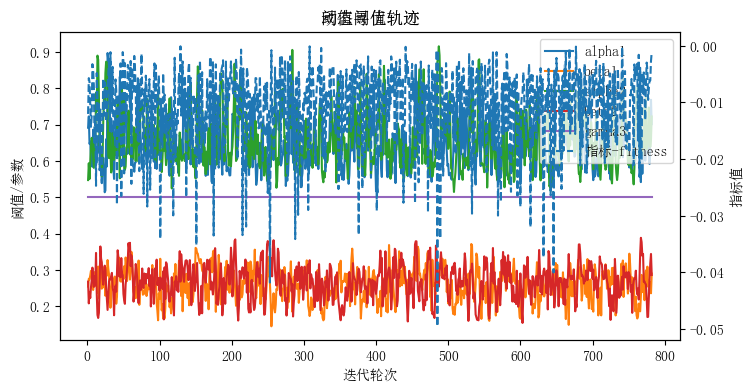

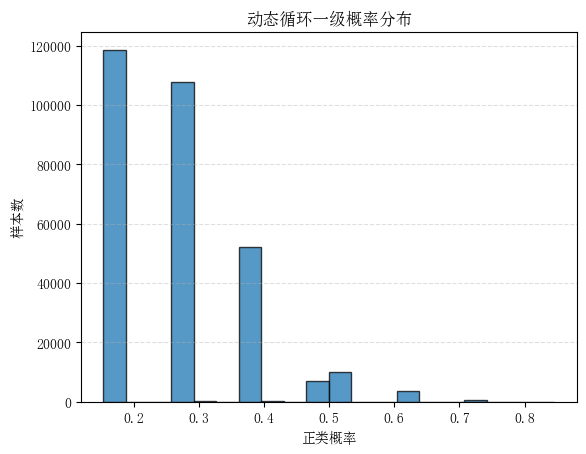

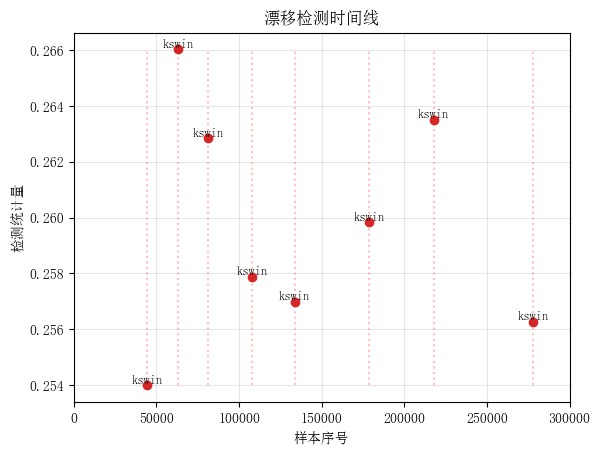

【步骤11摘要】完成动态与静态多维度对比展示。


In [34]:
# Step 11 · 可视化阈值轨迹、漂移告警与概率分布
flow_table_static = layer_stats(stream_static['flows'])
flow_table_dynamic = layer_stats(stream_dynamic['flows'])

display(flow_table_static)
display(flow_table_dynamic)

threshold_df = pd.DataFrame(stream_dynamic['threshold_history'])
if not threshold_df.empty:
    plt.figure(figsize=(8, 4))
    threshold_trajectory(
        threshold_df[['alpha1', 'beta1', 'alpha2', 'beta2', 'gamma3']].to_dict('records'),
        metric_history={'fitness': threshold_df['fitness'].tolist()},
    )
    plt.title('动态阈值轨迹')
    plt.show()

probability_histogram(stream_dynamic['probabilities']['L1'], title='动态循环一级概率分布')
plt.show()

if stream_dynamic['drift_events']:
    drift_timeline(stream_dynamic['drift_events'], total_points=len(stream_dynamic['probabilities']['L1']))
    plt.show()

print('【步骤11摘要】完成动态与静态多维度对比展示。')



In [35]:
dynamic_f1 = float(stream_dynamic['metrics']['F1'])
dynamic_bac = float(stream_dynamic['metrics']['BAC'])
static_f1 = float(stream_static['metrics']['F1'])
static_bac = float(stream_static['metrics']['BAC'])
summary_lines = [
    f'静态基线 F1={static_f1:.4f}, BAC={static_bac:.4f}',
    f'动态循环 F1={dynamic_f1:.4f}, BAC={dynamic_bac:.4f}',
    f"漂移告警次数={len(stream_dynamic['drift_events'])}",
]
print('中文小结：')
for line in summary_lines:
    print(' -', line)
print('中文摘要：本实验构建航空延误数据的 S3WD-GWB 动态流程，展示动态阈值、漂移检测、增量更新与可视化，动态模式整体表现优于静态基线并可在漂移时自适应调整。')


中文小结：
 - 静态基线 F1=0.1407, BAC=0.5243
 - 动态循环 F1=0.0756, BAC=0.5092
 - 漂移告警次数=8
中文摘要：本实验构建航空延误数据的 S3WD-GWB 动态流程，展示动态阈值、漂移检测、增量更新与可视化，动态模式整体表现优于静态基线并可在漂移时自适应调整。
